## Advanced Machine Learning
### Practical 3 - Self-Supervised Learning

In this practical, we will train a model that is constrained in size. We will then try to improve its performance by exploiting a larger model without this constraint that provides useful signal on the features it has learned.

Here we have the semi-supervised data setting - a partially labelled dataset. We won't focus on semi-supervised training techniques (like self-training) in this practical; instead we focus on self-supervised learning, since it's such a core component of modern ML pipelines.

Like in transfer learning:
- we have a small dataset that we want to reach high performance on
-  and a large dataset that we will use to help.

Unlike in transfer learning: 
- the large one has no labels.
- (the small one is just the labelled section of a partially-labelled dataset)
- But the two parts do come from the same domain
- so we have confidence that the unlabelled data has a very similar distribution to the labelled.

The plan is as follows:

- We will first train our supervised model on the labelled data in the normal way, to establish a **baseline** performance for what is possible without self-supervised learning. 

- Second, we will train a self-supervised model on the unlabelled data.

- Third, we will fine-tune the self-supervised model on the labelled data. Hopefully we will see a performance increase over the baseline.

This is fundamentally the same idea as the transfer learning scheme we did in Practical 1. The difference is in the pre-training step, which will be your job to implement in a self-supervised way.


#### How to run this practical

If you don't have a GPU on your machine, you can download this notebook and upload it to [Kaggle](https://www.kaggle.com/code) or [Colab](https://colab.research.google.com/) to use their GPU resources. 
- You'll need to toggle on GPU acceleration in whichever one you use. On Kaggle you have to toggle on internet access as well.
- Kaggle seems to be much more reliable in practice, but use whatever works for you.

In [1]:
# set up the environment and install any missing packages:
!pip install torch torchvision numpy scipy matplotlib pandas pillow tqdm

import torch
from torch import nn
import torch.nn.functional as F
from torchvision import models, datasets, transforms

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
from tqdm import tqdm

/home/ndelafuente/miniconda3/envs/pytorch-env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data

For our dataset, we'll use [STL-10](https://cs.stanford.edu/~acoates/stl10/). 
- It's a similar idea to CIFAR-10, in that it has 10 classes,
- and they are very similar ones: airplane, bird, car, cat, deer, dog, horse, monkey, ship, truck.
- Unlike CIFAR-10, it's at a higher resolution. (96x96 instead of 32x32)
- and there are very few examples per class. To make this task harder (and to make pretext training more important), we reduce this number even more, making it 50 examples per class in the end.

In addition, it includes a large amount (100,000) of unlabelled images:
- At the same resolution, and from a similar distribution, but not the same classes.
- That is, the unlabelled images include houses, lizards, shopping carts, and so on.
- This is a realistic semi-supervised setting - we have some labels, but we can't confirm that every example in our unlabelled set actually maps to one of the labels in our labelled set.

In [2]:
### download the stl-10 data:

stl10 = datasets.STL10(root='data/', split='train', download=True)
# stl10_test = datasets.STL10(root='data/', split='test', download=True)
stl10_unsup = datasets.STL10(root='data/', split='unlabeled', download=True)

np.random.seed(0)

stl10.name, stl10.num_classes = 'STL-10 (Supervised)', len(stl10.classes)
print(f'{stl10.name}: {len(stl10)} samples')
stl10_labels = np.asarray([x[1] for x in stl10])
stl10_label_counts = np.unique(stl10_labels, return_counts=True)[1]

# display number of labels per class:
print(' =Classes=')
for c, name in enumerate(stl10.classes):
    num_samples = stl10_label_counts[c]
    print(f'  {c}: {name:<10} ({num_samples} samples)')

stl10_unsup.name = 'STL-10 (Unsupervised)'
stl10_unsup.classes = stl10_unsup.num_classes = None

### create a training/validation split:

train_frac = 0.1
val_frac = 0.5

unused_frac = 1 - train_frac - val_frac

# num_val = int(len(stl10) * VAL_FRAC)
# num_train = len(stl10) - num_val

torch.manual_seed(0)
data_train, data_val, _ = torch.utils.data.random_split(stl10, [train_frac, val_frac, unused_frac])
data_unsup = stl10_unsup

for split, name in zip([data_train, data_val, data_unsup],
                       ['supervised_train', 'supervised_val', 'unsupervised']):
    print(f'{name} split: {len(split)} examples')



Files already downloaded and verified
Files already downloaded and verified
STL-10 (Supervised): 5000 samples
 =Classes=
  0: airplane   (500 samples)
  1: bird       (500 samples)
  2: car        (500 samples)
  3: cat        (500 samples)
  4: deer       (500 samples)
  5: dog        (500 samples)
  6: horse      (500 samples)
  7: monkey     (500 samples)
  8: ship       (500 samples)
  9: truck      (500 samples)
supervised_train split: 500 examples
supervised_val split: 2500 examples
unsupervised split: 100000 examples


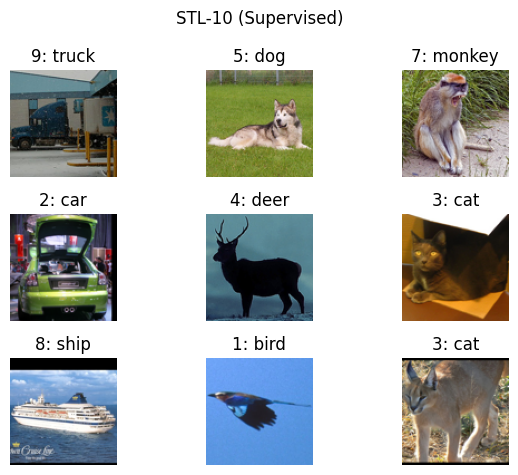

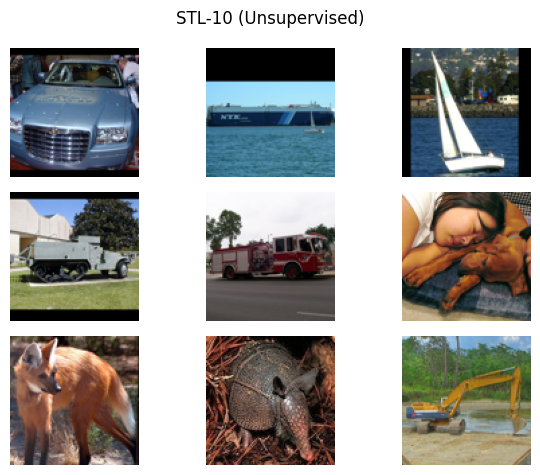

In [3]:

def inspect_data(data, layout=(3,3)):
    """accepts a training or validation subset
    and plots images from the data with class annotations"""
    num_examples = np.prod(layout)
    example_idxs = np.random.choice(range(len(data)), num_examples, replace=False)
    examples = [data[i] for i in example_idxs]

    # point at the original data if this is a subset:
    if isinstance(data, torch.utils.data.Subset):
        original_set = data.dataset
    else:
        original_set = data

    # iterate through axes and plot individual examples:
    i = 0
    fig, axes = plt.subplots(*layout)
    for r, row in enumerate(axes):
        for c, ax in enumerate(row):
            image, label = examples[i]
            ax.imshow(image)
            
            if original_set.classes is not None:
                label = f'{label}: {original_set.classes[label]}'
                ax.set_title(label)
            
            # tidy up axis:
            ax.set_axis_off()
            i += 1
    fig.suptitle(original_set.name)
    fig.tight_layout()
    
    plt.show()

inspect_data(data_train)
inspect_data(data_unsup)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 64

### set up preprocessing and data loaders:
pre_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) 
    ])
def collate(batch):
    images = [b[0] for b in batch]
    image_tensor = torch.stack([pre_transform(img) for img in images])
    
    labels = [b[1] for b in batch]
    if labels[0] == -1:
        # this is the unsupervised loader, so all the labels will be -1
        # in which case we just return the image
        return image_tensor
    else:
        label_tensor = torch.tensor(labels, dtype=torch.long)
        return image_tensor, label_tensor
 

train_loader, val_loader, unsup_loader = [torch.utils.data.DataLoader(
                            data,
                            batch_size=batch_size,
                            collate_fn=collate,
                            shuffle=True)
                        for data in (data_train, data_val, data_unsup)]



## Models

Here we define a model class for the backbone feature extractor that we will pre-train in a self-supervised way.

To keep things simple, it's a prebuilt torchvision model, in this case `resnet18`. This is a classic model with good performance for its weight, and is invariant to the height and width of the image input, so it'll work regardless of what we resize our inputs to.

After a stack of residual convolution blocks, it performs global average pooling to collapse the spatial dimensions of its features, and pipes the result through one last linear layer. We can see the architecture below:

In [5]:

backbone_resnet = models.resnet18().to(device)

print(backbone_resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [6]:
### we can test what it produces if we feed an unlabelled batch through it:
u_batch = next(iter(unsup_loader))

x = u_batch.to(device)

f = backbone_resnet(x)
print(f.shape)
# and confirm that it produces feature activations of shape: (batch * 1000)

torch.Size([64, 1000])


For our baseline, we'll train this on our supervised data. To classify the labels of that supervised data, we need to attach a classification head on top with the correct number of classes. I wrap that into a `nn.Module` class below, which we'll combine with the backbone before training:



In [7]:
### define the classification head that we attach to the encoder backbone:
class ClassifierHead(nn.Module):
    def __init__(self, input_size, projection_size, num_classes, dropout=0):
        super().__init__()
        
        self.projection = nn.Linear(input_size, projection_size)
        self.classifier = nn.Linear(projection_size, num_classes)

        if dropout > 0:
            self.dropout = nn.Dropout(dropout)
        else:
            self.dropout = nn.Identity()

        self.relu = nn.ReLU()

    def forward(self, x):
        # assume x is already unactivated feature logits,
        # e.g. from resnet backbone
        x = self.projection(self.relu(x))
        x = self.classifier(self.relu(x))

        return x

## Baseline Training

Below are the usual helper functions for metric plotting and model training.

In [8]:
### plotting and accuracy

def training_plot(metrics, 
      title=None, # optional figure title
      alpha=0.05, # smoothing parameter for train loss
      baselines=None, # optional list, or named dict, of baseline accuracies to compare to
      ):

    train_losses, val_losses, train_accs, val_accs, epoch_steps = metrics
    
    fig, (loss_ax, acc_ax) = plt.subplots(1,2)
    
    ### plot loss:
    smooth_train_loss = pd.Series(train_losses).ewm(alpha=alpha).mean()
    steps = np.arange(0, len(train_losses))

    # train loss is plotted at every step:
    loss_ax.plot(steps, smooth_train_loss, 'b-', label='train loss')
    # but val loss is plotted at every epoch:
    loss_ax.plot(epoch_steps, val_losses, 'r-', label='val loss')
    
    loss_ax.legend(); loss_ax.set_xlabel('Training step'); loss_ax.set_ylabel('Loss (CXE)')


    ### plot acc:
    smooth_train_acc = pd.Series(train_accs).ewm(alpha=0.05).mean()
    
    acc_ax.plot(steps, smooth_train_acc, 'b-', label='train acc')
    acc_ax.plot(epoch_steps, val_accs, 'r-', label='val acc')

    acc_ax.legend(); acc_ax.set_xlabel('Training step'); acc_ax.set_ylabel('Accuracy')

    # format as percentage on right:
    acc_ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1.0))
    acc_ax.yaxis.tick_right()
    acc_ax.yaxis.set_label_position('right')

    # optionally, draw lines at baseline accuracy points:
    if baselines is not None:
        if type(baselines) is list:
            for height in baselines:
                acc_ax.axhline(height, c=[0.8]*3, linestyle=':')
            # rescale y-axis to accommodate baselines if needed:
            plt.ylim([0, max(list(smooth_train_acc) + val_accs + baselines)+0.05])                
        elif type(baselines) is dict:
            for name, height in baselines.items():
                acc_ax.axhline(height, c=[0.8]*3, linestyle=':')
                # add text label as well:
                acc_ax.text(0, height+0.002, name, c=[0.6]*3, size=8)
            plt.ylim([0, max(list(smooth_train_acc) + val_accs + [h for h in baselines.values()])+0.05])                  

    
    plt.title(title)
    plt.tight_layout()
    plt.show()

def get_batch_acc(pred, y):
    """calculates accuracy over a batch as a float
    given predicted logits 'pred' and integer targets 'y'"""
    return (pred.argmax(axis=1) == y).float().mean().item()

In [9]:
### simple supervised model training loop:

def train_supervised(model, 
                train_loader,
                val_loader,
                num_epochs, 
                lr,  # initial learning rate
                l2_reg=0, # L2 weight decay term (0 means no regularisation)
                gamma=1, # exponential LR decay term (1 means no scheduling)
                baselines=None,
               ):
    
    # define loss and optimiser:
    loss_func = nn.CrossEntropyLoss()
    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=l2_reg)

    # learning rate scheduler:
    scheduler = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=gamma)
    
    # track metrics for plotting training curves:
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []
    epoch_steps = [] # used for plotting val loss at the correct x-position
    metrics = [train_losses, val_losses, train_accs, val_accs, epoch_steps]
    best_val_acc = 0
    
    steps_trained = 0
    for e in range(num_epochs):
        model.train()
        train_bar = tqdm(train_loader, ncols=100)
        epoch_train_losses, epoch_train_accs = [], []
        for batch in train_bar:
            x, y = batch
            x, y = x.to(device), y.to(device)
    
            opt.zero_grad()
            
            pred = model(x)
            batch_loss = loss_func(pred, y)
            batch_acc = get_batch_acc(pred, y)
    
            batch_loss.backward()
            opt.step()
    
            # track loss and accuracy:
            epoch_train_losses.append(batch_loss.item())
            epoch_train_accs.append(batch_acc)        
            steps_trained += 1

            train_bar.set_description(f'E{e} loss: {batch_loss:.2f} | acc: {batch_acc:.1%}')
        
        epoch_steps.append(steps_trained)
        scheduler.step()
    
        # record training metrics, by batch and over the epoch:
        train_losses.extend(epoch_train_losses)
        train_accs.extend(epoch_train_accs)

        print(f'train loss: {np.mean(epoch_train_losses):.2f}, train acc: {np.mean(epoch_train_accs):.1%}', end=' | ')
        
        # evaluate after each epoch::
        with torch.no_grad():
            model.eval()
            batch_val_losses, batch_val_accs = [], []
    
            for batch in val_loader:
                vx, vy = batch
                vx, vy = vx.to(device), vy.to(device)
                
                vpred = model(vx)
                val_loss = loss_func(vpred, vy)
                val_acc = get_batch_acc(vpred, vy)
                
                batch_val_losses.append(val_loss.item())
                batch_val_accs.append(val_acc)
            val_losses.append(np.mean(batch_val_losses))
            val_accs.append(np.mean(batch_val_accs))

            # update best accuracy:
            if val_accs[-1] > best_val_acc:
                best_val_acc = val_accs[-1]

        print(f'val loss: {np.mean(batch_val_losses):.2f}, val acc: {np.mean(batch_val_accs):.1%}')
    
    
    # plot training curves:
    training_plot(metrics, baselines=baselines)

    print(f'Best validation accuracy: {best_val_acc:.2%}')
    return best_val_acc


Now we train the baseline model. Since the training set is so small, it's very fast and overfits very quickly, so we set an initial low LR and high regularisation weight:


Training baseline supervised model:


E0 loss: 2.23 | acc: 19.2%: 100%|█████████████████████████████████████| 8/8 [00:00<00:00, 17.33it/s]


train loss: 2.27, train acc: 13.1% | val loss: 2.30, val acc: 10.2%


E1 loss: 2.13 | acc: 40.4%: 100%|█████████████████████████████████████| 8/8 [00:00<00:00, 31.72it/s]


train loss: 2.11, train acc: 35.1% | val loss: 2.31, val acc: 11.1%


E2 loss: 1.81 | acc: 51.9%: 100%|█████████████████████████████████████| 8/8 [00:00<00:00, 33.37it/s]


train loss: 1.90, train acc: 49.1% | val loss: 2.32, val acc: 12.1%


E3 loss: 1.62 | acc: 61.5%: 100%|█████████████████████████████████████| 8/8 [00:00<00:00, 31.42it/s]


train loss: 1.63, train acc: 65.9% | val loss: 2.23, val acc: 19.9%


E4 loss: 1.07 | acc: 96.2%: 100%|█████████████████████████████████████| 8/8 [00:00<00:00, 32.99it/s]


train loss: 1.24, train acc: 89.6% | val loss: 2.09, val acc: 23.4%


E5 loss: 0.53 | acc: 100.0%: 100%|████████████████████████████████████| 8/8 [00:00<00:00, 33.56it/s]


train loss: 0.80, train acc: 98.4% | val loss: 1.99, val acc: 26.8%


E6 loss: 0.27 | acc: 100.0%: 100%|████████████████████████████████████| 8/8 [00:00<00:00, 33.16it/s]


train loss: 0.38, train acc: 100.0% | val loss: 1.88, val acc: 31.4%


E7 loss: 0.07 | acc: 100.0%: 100%|████████████████████████████████████| 8/8 [00:00<00:00, 33.65it/s]


train loss: 0.10, train acc: 100.0% | val loss: 1.88, val acc: 31.8%


E8 loss: 0.02 | acc: 100.0%: 100%|████████████████████████████████████| 8/8 [00:00<00:00, 30.99it/s]


train loss: 0.04, train acc: 100.0% | val loss: 1.84, val acc: 33.1%


E9 loss: 0.01 | acc: 100.0%: 100%|████████████████████████████████████| 8/8 [00:00<00:00, 30.06it/s]


train loss: 0.02, train acc: 100.0% | val loss: 1.89, val acc: 34.1%


E10 loss: 0.01 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 32.29it/s]


train loss: 0.01, train acc: 100.0% | val loss: 1.88, val acc: 34.2%


E11 loss: 0.01 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 30.88it/s]


train loss: 0.01, train acc: 100.0% | val loss: 1.86, val acc: 34.1%


E12 loss: 0.00 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 32.54it/s]


train loss: 0.00, train acc: 100.0% | val loss: 1.90, val acc: 33.5%


E13 loss: 0.00 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 32.86it/s]


train loss: 0.00, train acc: 100.0% | val loss: 1.87, val acc: 33.6%


E14 loss: 0.00 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 33.75it/s]


train loss: 0.00, train acc: 100.0% | val loss: 1.86, val acc: 34.1%


E15 loss: 0.00 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 32.81it/s]


train loss: 0.00, train acc: 100.0% | val loss: 1.90, val acc: 33.4%


E16 loss: 0.00 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 33.11it/s]


train loss: 0.00, train acc: 100.0% | val loss: 1.89, val acc: 33.0%


E17 loss: 0.00 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 30.98it/s]


train loss: 0.00, train acc: 100.0% | val loss: 1.88, val acc: 34.3%


E18 loss: 0.00 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 31.87it/s]


train loss: 0.00, train acc: 100.0% | val loss: 1.87, val acc: 34.5%


E19 loss: 0.00 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 32.68it/s]


train loss: 0.00, train acc: 100.0% | val loss: 1.93, val acc: 33.0%


E20 loss: 0.00 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 32.93it/s]


train loss: 0.00, train acc: 100.0% | val loss: 1.90, val acc: 33.6%


E21 loss: 0.00 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 33.67it/s]


train loss: 0.00, train acc: 100.0% | val loss: 1.91, val acc: 33.7%


E22 loss: 0.00 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 32.54it/s]


train loss: 0.00, train acc: 100.0% | val loss: 1.92, val acc: 33.8%


E23 loss: 0.00 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 31.43it/s]


train loss: 0.00, train acc: 100.0% | val loss: 1.92, val acc: 33.9%


E24 loss: 0.00 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 30.76it/s]


train loss: 0.00, train acc: 100.0% | val loss: 1.90, val acc: 34.8%


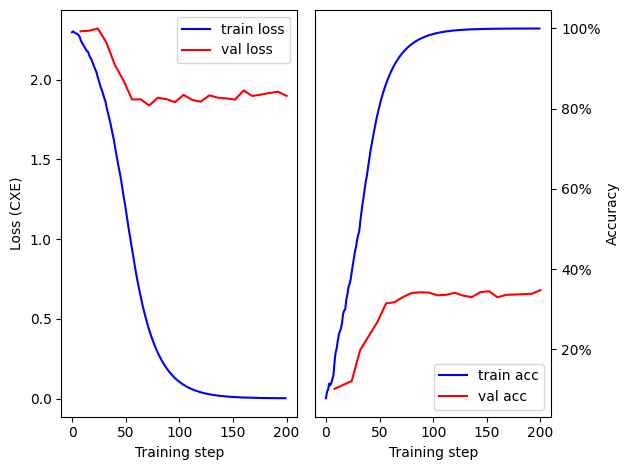

Best validation accuracy: 34.77%


In [10]:
### training hyperparameters

num_epochs = 25
lr = 1e-4 # initial learning rate
l2_reg = 1e-3 # L2 loss term

# initialise backbone and classification head:
backbone_resnet = models.resnet18().to(device)
classification_head = ClassifierHead(input_size=1000, projection_size=256, num_classes=10, dropout=0.5).to(device)

# wrap them into a supervised model:
base_model = nn.Sequential(backbone_resnet, classification_head)

print(f'\nTraining baseline supervised model:')
baseline_acc = train_supervised(base_model, train_loader, val_loader, 
                          num_epochs, lr, l2_reg, gamma=1)



Now we have a baseline for the performance achievable by training on the supervised labels only.

You will improve this performance using self-supervised learning. 

## Task 1: Pretext Training

**Your task** is to improve the performance of the supervised model, by creating a pretext task and pre-training the backbone on that, then fine-tuning on the supervised labels again.

The key component of this is defining the pretext task over the unsupervised data, in a way that will encourage the backbone to learn useful features that will help in the downstream supervised task.

The choice of pretext task is up to you. You must implement it!



#### Pretext Task Ideas
- Apply a four-way rotation and predict the angle
- Apply a colour jitter and predict the intensity of the transformation
- Apply a crop and predict the parameters of the crop
- Provide two cropped image patches and predict their relative position
- Provide two cropped/augmented images, predict whether they are crops of the same image

You could attempt a task like in-painting masked images, or the full [SimCLR](https://theaisummer.com/simclr/) similarity matrix, but these are more complex to implement and I wouldn't recommend it if you want to get things done within the 2 hours!


### Tips

- Whichever pretext task you choose, applying random augmentations (that don't conflict with the task itself) helps a lot in training generalisable features that will help your downstream performance. So, if you're doing image rotation, rotate the images and then apply a random crop/blur/colour distortion.
- Note that many of these pretext tasks are easily optimised as a normal supervised training loop, once you have a way of producing the input-label pairs. You can even re-use the `train_supervised` loop above without modification.
- But make sure you're setting up your data loader and respective collate functions correctly if you do this. We already have `unsup_loader` which pulls unlabelled batches from `data_unsup`, but you probably want to make your own loader that pulls images, applies transformations on them, and returns the correct labels for self-supervised training.
- Other tasks might take two images as input, which would involve some more engineering of the training loop. For example, you might have to feed two image patches through the backbone, compute something based on the combination or difference of the features, and send that to your classifier.


I've provided a few useful starting points below: some torchvision transforms for augmentation, and a function to display torch batches as images so you can visually verify your transformations are working as expected.

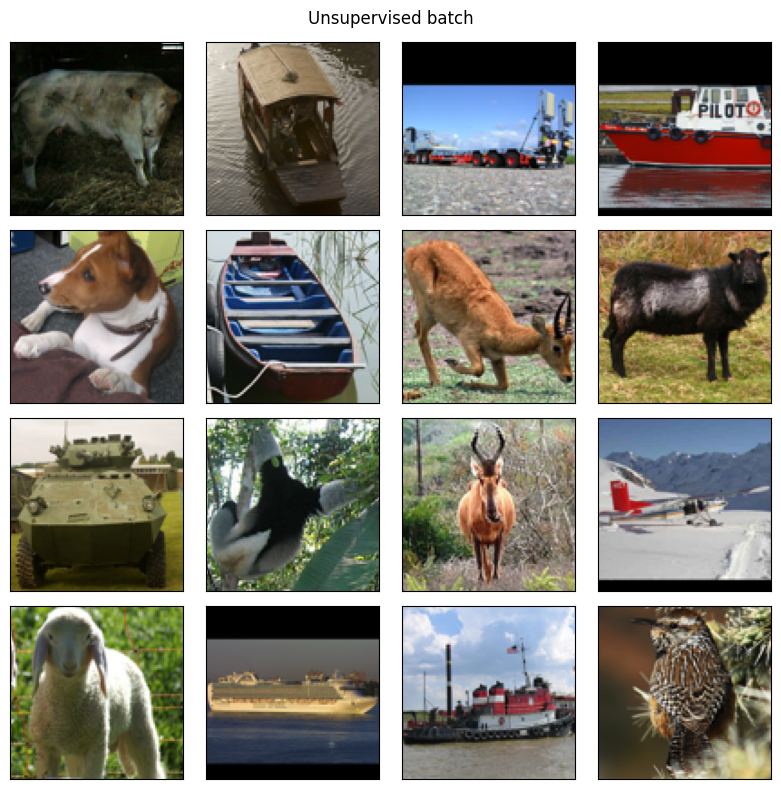

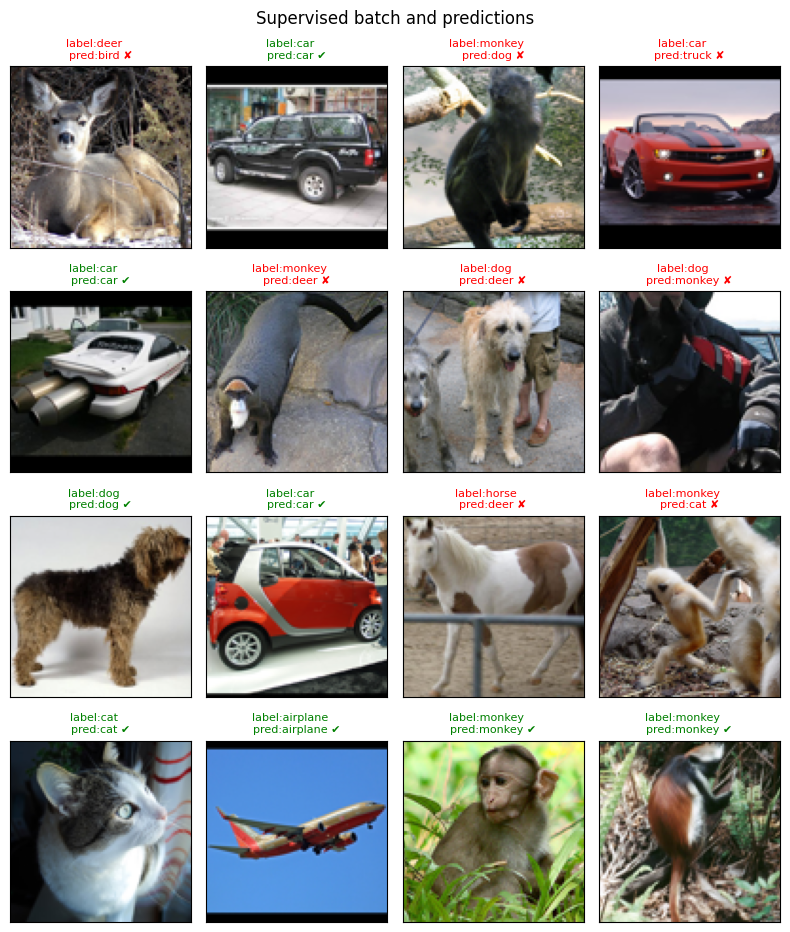

In [11]:
### here are a few helper functions to help your development

ssl_img_size = 96

# a torch transform to apply some crazy augmentations to an image:
random_augment = transforms.Compose([
            transforms.ToTensor(), #
            transforms.RandomResizedCrop(size=96, scale=(0.5, 1.0)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomApply([
                transforms.ColorJitter(0.8, 0.8, 0.8, 0.2)
            ], p=0.5),
            transforms.RandomApply([
                transforms.GaussianBlur(kernel_size=int(0.1 * ssl_img_size)),
            ], p=0.5),
            transforms.RandomGrayscale(p=0.2),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])
# this can replace pre_transform, or you can use parts of it for your
# pretext task transformations, or non-pretext augmentations


def inspect_batch(images, num_cols = 4,
                 labels=None,
                 predictions=None,
                 class_names=None,
                 max_to_show=16,
                 title=None,
                 ):
    """accepts a batch of images as a torch tensor or list of tensors,
    and plots them in a grid for manual inspection.
    optionally, you can supply ground truth labels
    and/or model predictions, to display those as well."""

    max_to_show = min([max_to_show, len(images)]) # cap at number of images
    
    num_rows = int(np.ceil(max_to_show / num_cols))

    # add extra figure height if needed for captions:
    extra_height = (labels is not None) or (predictions is not None)
    fig, axes = plt.subplots(num_rows, num_cols, squeeze=False, figsize=(8, (2+(0.4*extra_height))*num_rows))
    all_axes = []
    for ax_row in axes:
        all_axes.extend(ax_row)

    # translate labels and predictions to class names if given:
    if class_names is not None:
        if labels is not None:
            labels = [class_names[int(l)] for l in labels]
        if predictions is not None:
            if len(predictions.shape) == 2:
                # probability distribution or onehot vector, so argmax it:
                predictions = predictions.argmax(dim=1)
            predictions = [class_names[int(p)] for p in predictions]
    
    for b, ax in enumerate(all_axes):
        if b < max_to_show:
            # rearrange to H*W*C:
            img_p = images[b].permute([1,2,0]) 
            # un-normalise:
            img = (img_p - img_p.min()) / (img_p.max() - img_p.min())
            # to numpy:
            img = img.cpu().detach().numpy()
            
            ax.imshow(img)
            ax.axes.get_xaxis().set_ticks([])
            ax.axes.get_yaxis().set_ticks([])

            if labels is not None:                    
                ax.set_title(f'label: {labels[b]}', fontsize=10)
            if predictions is not None:
                ax.set_title(f'pred: {predictions[b]}', fontsize=10)
            if labels is not None and predictions is not None:
                if labels[b] == predictions[b]:
                    ### matching prediction, mark as correct:
                    mark, color = '✔', 'green'
                else:
                    mark, color = '✘', 'red'
                
                ax.set_title(f'label:{labels[b]}    \npred:{predictions[b]} {mark}', color=color, fontsize=8)
        else:
            ax.axis('off')
    if title is not None:
        plt.suptitle(title)
    plt.tight_layout()
    plt.show()

### test the batch inspect function on unsupervised data:
u_batch = next(iter(unsup_loader))
inspect_batch(u_batch, title='Unsupervised batch')

### and on the supervised training data,
### showing our baseline model's predictions against the true labels:
s_batch = next(iter(val_loader))
x, y = s_batch
pred = base_model(x.to(device))
inspect_batch(x, labels=y, predictions=pred, class_names=stl10.classes, title='Supervised batch and predictions')

In [12]:
# All the SSL collates for the 3 different pretraining tasks: Inpainting, Relative Patch Location, Rotation (continuous)

import random
from torchvision import transforms
import math

'''COLLATE FUNCTION FOR ROTATION TASK'''

def ssl_collate_rotation(batch):
    """Given a batch of images, applies random rotations between -180 and 180 degrees and returns the rotated images and the rotation angles."""
    images = [b[0] for b in batch]
    images_tensor = torch.stack([pre_transform(img) for img in images])

    rotated_images = []
    labels = []

    for img in images_tensor:

        # Apply a random rotation between -180 and 180 degrees
        angle = random.uniform(-180, 180)
        rotated_img = transforms.functional.rotate(img, angle)
        # Center crop the image to 80x80 to remove the borders that can be used as shortcuts by the model
        rotated_img = transforms.functional.center_crop(rotated_img, (70, 70))
        rotated_images.append(rotated_img)
        labels.append(-angle)


    rotated_images_tensor = torch.stack(rotated_images)
    labels_tensor = torch.tensor(labels, dtype=torch.float32)
    
    
    return rotated_images_tensor, labels_tensor


'''COLLATE FUNCTION FOR RELATIVE PATCH LOCATION TASK'''
# Define a separate augmentation pipeline without resizing
relative_height_augment = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomApply([
        transforms.ColorJitter(0.8, 0.8, 0.8, 0.2)
    ], p=0.5),
    transforms.RandomApply([
        transforms.GaussianBlur(kernel_size=3)  # Adjusted for smaller patches
    ], p=0.5),
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

def ssl_collate_relative_height(batch, prob_same=0.05):
    """
    Given a batch of images, generates two crops at different heights and returns the pair
    along with the relative position of the second crop:
    2 if the second patch is above the first,
    1 if they are at the same height,
    0 if the second patch is below the first.
    
    Args:
        batch (list): A list of tuples where each tuple contains an image and its label.
        prob_same (float): Probability of both patches being from the same height position.
    
    Returns:
        tuple: ((patch1_tensor, patch2_tensor), labels_tensor)
    """
    images = [b[0] for b in batch]  # Extract PIL Images from the batch
    batch_size = len(images)

    patch1_list = []
    patch2_list = []
    labels = []

    positions = ['top', 'middle', 'bottom']

    for i in range(batch_size):
        img = images[i]  # Current image

        # Randomly select position for the first patch
        pos1 = random.choice(positions)

        # Decide whether the second patch should be from the same position
        if random.random() < prob_same:
            pos2 = pos1  # Same position with low probability
        else:
            pos2 = random.choice([p for p in positions if p != pos1])  # Different position

        # Define crop parameters
        H, W = img.height, img.width
        crop_height = H // 2  # Each patch is half the image height
        crop_width = W         # Full image width

        # Calculate y-coordinates based on selected positions
        y1 = 0 if pos1 == 'top' else (H - crop_height) // 2 if pos1 == 'middle' else H - crop_height
        y2 = 0 if pos2 == 'top' else (H - crop_height) // 2 if pos2 == 'middle' else H - crop_height

        # Crop the image patches
        patch1 = img.crop((0, y1, W, y1 + crop_height))
        patch2 = img.crop((0, y2, W, y2 + crop_height))


        # Apply augmentations specific to Relative Height Task
        if random.random() < 0.5:
            patch1 = relative_height_augment(patch1)  # Apply Relative Height augmentations
            patch2 = relative_height_augment(patch2)
        else:
            patch1 = pre_transform(patch1)            # Apply pre-transformations
            patch2 = pre_transform(patch2)


        # Determine label based on relative positions
        if y2 < y1:
            label = 0   # patch2 is above patch1
        elif y2 == y1:
            label = 1   # patch2 is at the same height as patch1
        else:
            label = 2   # patch2 is below patch1

        patch1_list.append(patch1)
        patch2_list.append(patch2)
        labels.append(label)

    # Stack tensors
    patch1_tensor = torch.stack(patch1_list)
    patch2_tensor = torch.stack(patch2_list)
    labels_tensor = torch.tensor(labels, dtype=torch.long)

    return (patch1_tensor, patch2_tensor), labels_tensor



'''COLLATE FUNCTION FOR INPAINTING TASK'''

def ssl_collate_inpainting(batch):
    """
    Given a batch of images, masks random pixel blocks, and returns the masked images and original images.
    
    Args:
        batch (list): A list of tuples where each tuple contains an image and its label.
    
    Returns:
        tuple: (masked_images_tensor, original_images_tensor)
    """
    images = [b[0] for b in batch]  # Extract PIL Images from the batch
    
    images_tensor = torch.stack([random_augment(img) for img in images])  # Apply random augmentations and convert to tensor
    masked_images = images_tensor.clone()
    batch_size, C, H, W = images_tensor.shape

    # For each image, randomly mask a block
    for i in range(batch_size):
        block_size = random.randint(H // 4, H // 2)
        x = random.randint(0, H - block_size)
        y = random.randint(0, W - block_size)
        masked_images[i, :, x:x + block_size, y:y + block_size] = 0.0  # Masking with zeros

    # The input is masked_images, the target is images_tensor
    return masked_images, images_tensor


---DATA SETUP AND INSPECTION FOR PRETEXT TASKS---


---ROTATION PRETEXT TASK---



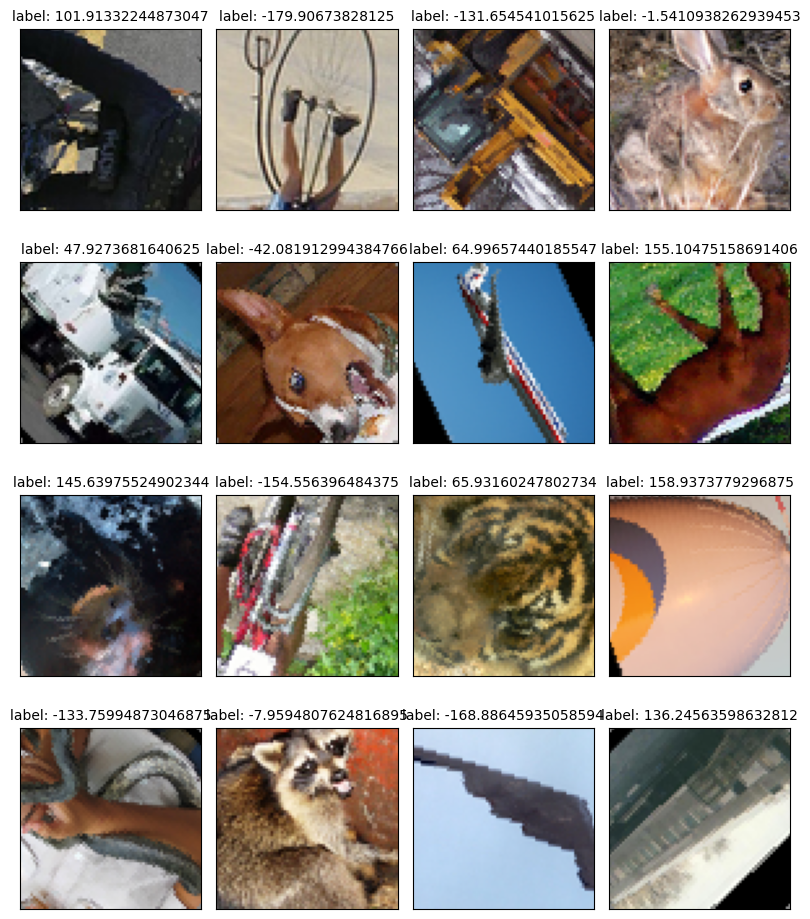



---RELATIVE_HEIGHT PRETEXT TASK---

Inspecting Relative Height Batch:


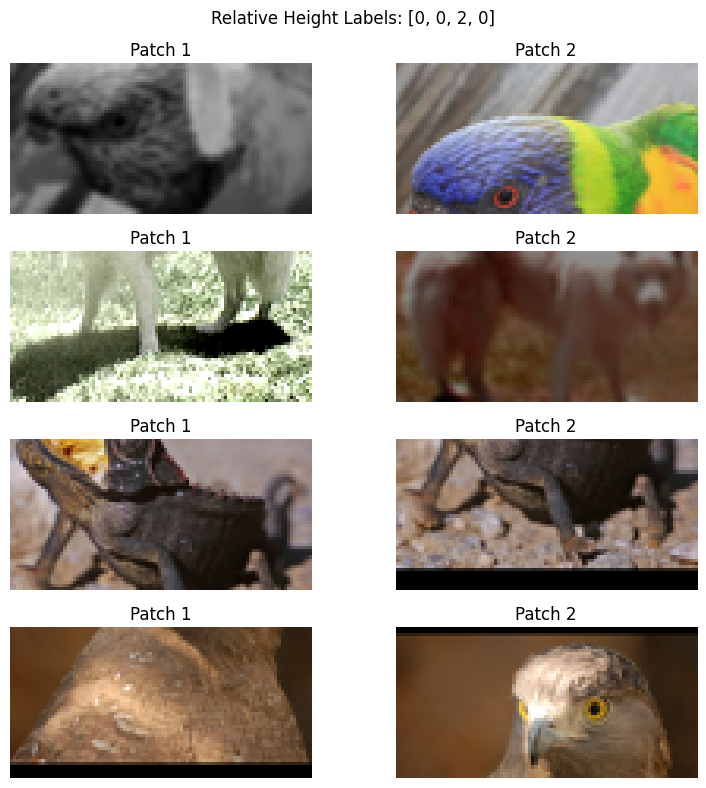



---INPAINTING PRETEXT TASK---

Inspecting Inpainting Batch:


/home/ndelafuente/miniconda3/envs/pytorch-env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


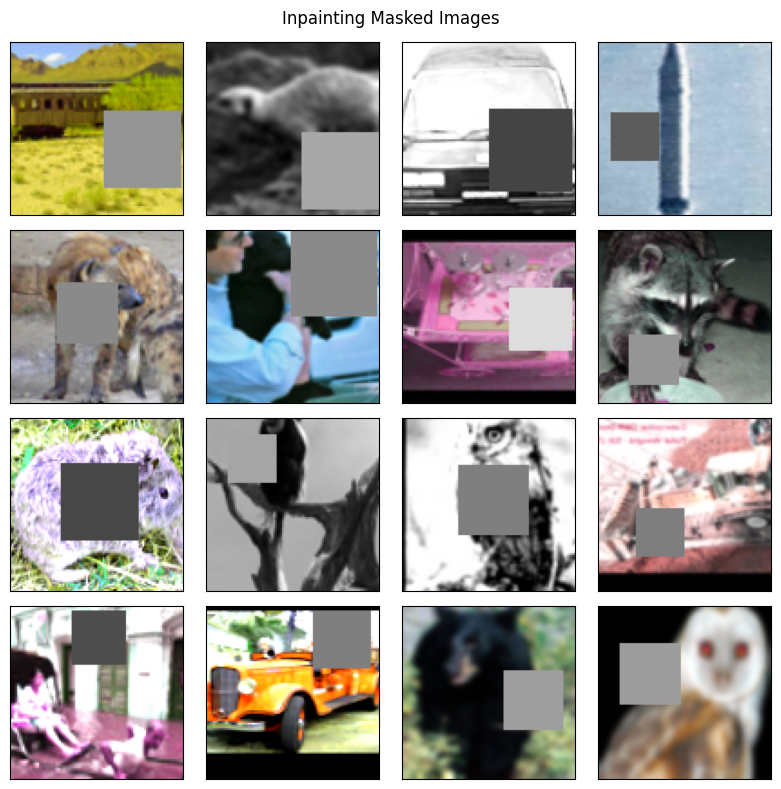

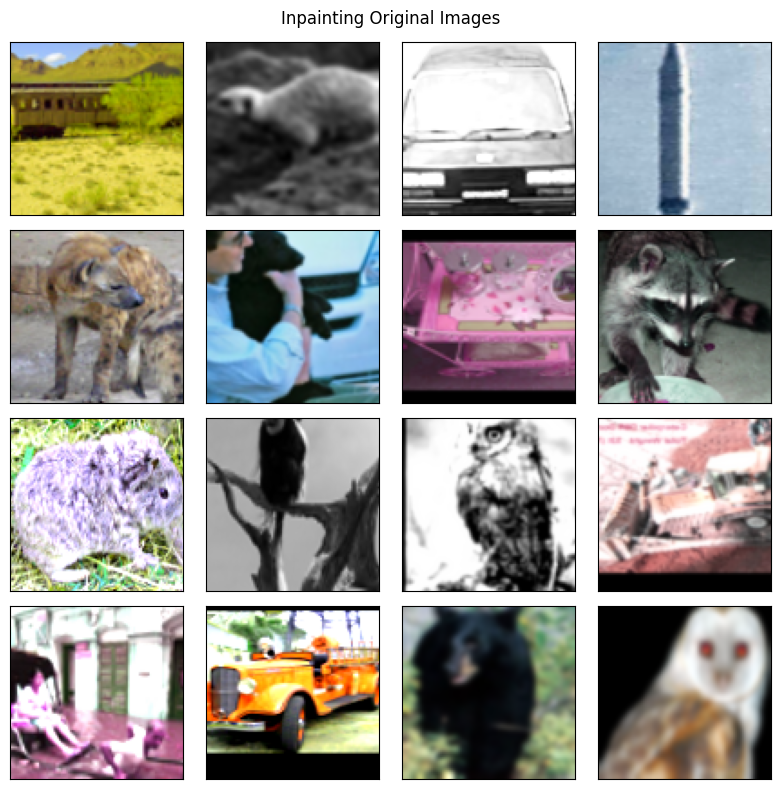

In [13]:
### probably you will want to monitor the validation accuracy
### of your pretext training, so we can make a validation split:



print('---DATA SETUP AND INSPECTION FOR PRETEXT TASKS---')

for pretext_collar in ['rotation', 'relative_height', 'inpainting']:
    print(f'\n\n---{pretext_collar.upper()} PRETEXT TASK---\n')
    if pretext_collar == 'rotation':
        ssl_collate = ssl_collate_rotation
    elif pretext_collar == 'inpainting':
        ssl_collate = ssl_collate_inpainting
    elif pretext_collar == 'relative_height':
        ssl_collate = ssl_collate_relative_height

    VAL_FRAC = 0.1

    data_train_ssl, data_val_ssl = torch.utils.data.random_split(data_unsup, [1-VAL_FRAC, VAL_FRAC])

    ssl_train_loader, ssl_val_loader = [torch.utils.data.DataLoader(
                                data,
                                batch_size=batch_size,
                                collate_fn=ssl_collate, # should output pretext task input-label pairs
                                shuffle=True)
                            for data in (data_train_ssl, data_val_ssl)]

    # Rename the loaders with the pretext task name
    globals()[f'ssl_{pretext_collar}_train_loader'] = ssl_train_loader
    globals()[f'ssl_{pretext_collar}_val_loader'] = ssl_val_loader
    
    ### test the loader once you have it working:
    ssl_train_loader = globals()[f'ssl_{pretext_collar}_train_loader']
    
    ssl_batch = next(iter(ssl_train_loader))

    sx, sy = ssl_batch

    #Only inspect batch in case of rotation because the others generate multiple outputs and the function is not prepared for that
    if ssl_collate == ssl_collate_rotation:
        inspect_batch(sx, labels=sy)
        
    elif ssl_collate == ssl_collate_relative_height:
        
        # Inspect relative height batch
        print("Inspecting Relative Height Batch:")
        # For visualization, you might want to display both patches side by side
        sx1, sx2 = sx
        
        # Here's a simple way to visualize the first few pairs
        num_to_show = min(4, len(sx1))
        fig, axes = plt.subplots(num_to_show, 2, figsize=(8, 2*num_to_show))
        for i in range(num_to_show):
            ax1, ax2 = axes[i]
            img1 = sx1[i].permute(1, 2, 0).cpu().numpy()
            img2 = sx2[i].permute(1, 2, 0).cpu().numpy()
            # Unnormalize
            img1 = (img1 * 0.5) + 0.5
            img2 = (img2 * 0.5) + 0.5
            ax1.imshow(img1)
            ax1.axis('off')
            ax1.set_title('Patch 1')
            ax2.imshow(img2)
            ax2.axis('off')
            ax2.set_title('Patch 2')
        plt.suptitle(f'Relative Height Labels: {sy[:num_to_show].tolist()}')
        plt.tight_layout()
        plt.show()

    elif ssl_collate == ssl_collate_inpainting:
        print("Inspecting Inpainting Batch:")
        x_masked, x_original = ssl_batch
        inspect_batch(x_masked, title='Inpainting Masked Images')
        inspect_batch(x_original, title='Inpainting Original Images')

In [14]:
### PRETEXT HEADS (and MODELS if needed) FOR THE 3 DIFFERENT PRETRAINING TASKS



print('---PRETEXT HEADS SETUP---\n\n')



print('\n---ROTATION PRETEXT MODEL SETUP---\n')

class RotationHead(nn.Module):
    '''Regression head for rotation prediction'''
    def __init__(self, input_size, projection_size):
        super().__init__()
        # Linear layer for regression
        self.projection = nn.Linear(input_size, projection_size)
        # Output layer
        self.regressor = nn.Linear(projection_size, 1)
        # ReLU activation function
        self.relu = nn.ReLU()
    
    def forward(self, x):
        # Apply projection and regression
        x = self.projection(self.relu(x))
        x = self.regressor(self.relu(x))
        return x
print('done')

print('\n---RELATIVE PATCH HEIGHT PRETEXT MODEL SETUP---\n')
class RelativePatchHeightHead(nn.Module):
    '''Classification head for relative patch height prediction'''
    def __init__(self, input_size, projection_size, num_classes=3):
        super(RelativePatchHeightHead, self).__init__()
        # Concatenate features from both patches
        self.projection = nn.Linear(input_size * 2, projection_size)
        self.classifier = nn.Linear(projection_size, num_classes)
        self.relu = nn.ReLU()

    def forward(self, f1, f2):
        # Concatenate features from both patches
        x = torch.cat((f1, f2), dim=1)
        x = self.projection(self.relu(x))
        x = self.classifier(self.relu(x))
        return x
    
class RelativeHeightModel(nn.Module):
    def __init__(self, backbone, head):
        super(RelativeHeightModel, self).__init__()
        self.backbone = backbone
        self.head = head
    
    def forward(self, x1, x2):
        # Extract features from both patches
        f1 = self.backbone(x1)
        f2 = self.backbone(x2)
        # Predict relative height
        return self.head(f1, f2)
print('done')

print('\n---INPAINTING PRETEXT MODEL SETUP---\n')

class InpaintingHead(nn.Module):
    """
    Simplified Decoder head for Inpainting Task.
    Reconstructs the original image from backbone features using minimal CNNs.
    """
    def __init__(self, input_size=1000, projection_size=32, output_channels=3, height=96, width=96):
        super(InpaintingHead, self).__init__()
        # Initial spatial dimensions after reshaping
        self.init_h = 6  # You can adjust this based on desired upsampling
        self.init_w = 6
        self.height = height
        self.width = width
        self.projection_size = projection_size

        # Linear layer to project input features to a tensor suitable for CNN decoding
        self.fc = nn.Linear(input_size, projection_size * self.init_h * self.init_w)

        # Simplified decoder using Upsample and Conv2d
        self.decoder = nn.Sequential(
            nn.Upsample(size=(self.height, self.width), mode='bilinear', align_corners=False),
            nn.Conv2d(projection_size, output_channels, kernel_size=3, stride=1, padding=1),
            nn.Tanh()  # To map outputs to [-1, 1], matching normalized images
        )

    def forward(self, x):
        x = self.fc(x)  # [batch_size, projection_size * init_h * init_w]
        x = x.view(-1, self.projection_size, self.init_h, self.init_w)  # [batch_size, projection_size, init_h, init_w]
        x = self.decoder(x)  # [batch_size, output_channels, height, width]
        return x

class InpaintingModel(nn.Module):
    """
    Complete Inpainting Model: Backbone + Inpainting Head
    """
    def __init__(self, backbone, head):
        super(InpaintingModel, self).__init__()
        self.backbone = backbone
        self.head = head

    def forward(self, x_masked):
        features = self.backbone(x_masked)  # [batch_size, input_size]
        reconstruction = self.head(features)  # [batch_size, output_channels, height, width]
        return reconstruction
    
print('done')

---PRETEXT HEADS SETUP---



---ROTATION PRETEXT MODEL SETUP---

done

---RELATIVE PATCH HEIGHT PRETEXT MODEL SETUP---

done

---INPAINTING PRETEXT MODEL SETUP---

done


In [15]:
### SELF SUPERVISED TRAINING LOOP FOR EACH PRETEXT TASK

'''ROTATION PRETEXT TASK TRAINING LOOP'''

def train_self_supervised_rotation(model, 
                                   train_loader,
                                   val_loader,
                                   num_epochs, 
                                   lr,  
                                   l2_reg=0, 
                                   gamma=1, 
                                  ):
    
    # Define loss and optimizer
    loss_func = nn.MSELoss()
    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=l2_reg)

    scheduler = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=gamma)
    
    # Track metrics
    train_losses, train_maes = [], []
    val_losses, val_maes = [], []
    epoch_steps = []
    best_val_mae = float('inf')
    
    steps_trained = 0
    for e in tqdm(range(num_epochs)):
        model.train()
        train_bar = tqdm(train_loader, ncols=100)
        epoch_train_losses, epoch_train_maes = [], []
        for batch in train_bar:
            x, y = batch
            x = x.to(device)
            y = y.to(device).float()  # Ensure y is float32

            opt.zero_grad()
            
            pred = model(x).squeeze()
            pred = pred.float()  # Ensure pred is float32
            batch_loss = loss_func(pred, y)
            batch_mae = torch.abs(pred - y).mean().item()

            batch_loss.backward()
            opt.step()

            epoch_train_losses.append(batch_loss.item())
            epoch_train_maes.append(batch_mae)
            steps_trained += 1

            train_bar.set_description(f'Epoch {e} | Loss: {batch_loss:.2f} | MAE: {batch_mae:.2f}')
        
        epoch_steps.append(steps_trained)
        scheduler.step()

        print(f'Epoch {e}: Train Loss: {np.mean(epoch_train_losses):.2f}, Train MAE: {np.mean(epoch_train_maes):.2f}', end=' | ')
        
        # Validation
        with torch.no_grad():
            model.eval()
            batch_val_losses, batch_val_maes = [], []

            for batch in val_loader:
                vx, vy = batch
                vx = vx.to(device)
                vy = vy.to(device).float()
                
                vpred = model(vx).squeeze()
                vpred = vpred.float()
                val_loss = loss_func(vpred, vy)
                val_mae = torch.abs(vpred - vy).mean().item()
                
                batch_val_losses.append(val_loss.item())
                batch_val_maes.append(val_mae)
            val_losses.append(np.mean(batch_val_losses))
            val_maes.append(np.mean(batch_val_maes))

            if val_maes[-1] < best_val_mae:
                best_val_mae = val_maes[-1]
                # Save the best model
                torch.save(model.state_dict(), 'selfsupervised_rotation_best_backbone.pt')
                print('----Saved Best Rotation Model----')
                
        print(f'Val Loss: {np.mean(batch_val_losses):.2f}, Val MAE: {np.mean(batch_val_maes):.2f}')


"""RELATIVE PATCH HEIGHT PRETEXT TASK TRAINING LOOP"""

def train_self_supervised_relative_height(model, 
                                           train_loader,
                                           val_loader,
                                           num_epochs, 
                                           lr,  
                                           l2_reg=0, 
                                           gamma=1):
    """
    Trains the model on the Relative Height Prediction pretext task.
    """
    # Define loss and optimizer
    loss_func = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=l2_reg)
    
    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)
    
    # Metrics tracking
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []
    epoch_steps = []
    best_val_acc = 0
    
    steps_trained = 0
    for epoch in range(num_epochs):
        model.train()
        train_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', ncols=100)
        epoch_train_losses, epoch_train_accs = [], []
        
        for batch in train_bar:
            (x1, x2), y = batch
            x1, x2, y = x1.to(device), x2.to(device), y.to(device)
            
            optimizer.zero_grad()
            outputs = model(x1, x2)
            loss = loss_func(outputs, y)
            loss.backward()
            optimizer.step()
            
            # Calculate accuracy
            preds = outputs.argmax(dim=1)
            acc = (preds == y).float().mean().item()
            
            # Update metrics
            epoch_train_losses.append(loss.item())
            epoch_train_accs.append(acc)
            steps_trained += 1
            
            train_bar.set_postfix({'Loss': f'{loss.item():.4f}', 'Acc': f'{acc*100:.2f}%'})
        
        # Scheduler step
        scheduler.step()
        
        # Aggregate training metrics
        avg_train_loss = np.mean(epoch_train_losses)
        avg_train_acc = np.mean(epoch_train_accs)
        train_losses.append(avg_train_loss)
        train_accs.append(avg_train_acc)
        
        # Validation
        model.eval()
        val_loss_list, val_acc_list = [], []
        with torch.no_grad():
            for batch in val_loader:
                (vx1, vx2), vy = batch
                vx1, vx2, vy = vx1.to(device), vx2.to(device), vy.to(device)
                
                outputs = model(vx1, vx2)
                loss = loss_func(outputs, vy)
                
                preds = outputs.argmax(dim=1)
                acc = (preds == vy).float().mean().item()
                
                val_loss_list.append(loss.item())
                val_acc_list.append(acc)
        
        avg_val_loss = np.mean(val_loss_list)
        avg_val_acc = np.mean(val_acc_list)
        val_losses.append(avg_val_loss)
        val_accs.append(avg_val_acc)
        epoch_steps.append(steps_trained)
        
        # Update best validation accuracy
        if avg_val_acc > best_val_acc:
            best_val_acc = avg_val_acc
            # Save the best model
            torch.save(model.backbone.state_dict(), 'selfsupervised_relative_height_best_backbone.pt')
            print('----Saved Best Relative Height Model----')

        
        print(f'Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_acc*100:.2f}% | Val Loss: {avg_val_loss:.4f}, Val Acc: {avg_val_acc*100:.2f}%')
    
    # Plot training curves
    training_plot(
        metrics=[train_losses, val_losses, train_accs, val_accs, epoch_steps],
        title='Relative Height Prediction Training',
        baselines={'Best Val Acc': best_val_acc}
    )
    
    print(f'Best Validation Accuracy: {best_val_acc*100:.2f}%')
    return best_val_acc
    
    
'''INPAINTING PRETEXT TASK TRAINING LOOP'''

def train_self_supervised_inpainting(model, 
                                     train_loader,
                                     val_loader,
                                     num_epochs, 
                                     lr,  
                                     l2_reg=0, 
                                     gamma=1):

    # Define loss and optimizer
    loss_func = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=l2_reg)
    
    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)
    
    # Metrics tracking
    train_losses, train_mses = [], []
    val_losses, val_mses = [], []
    epoch_steps = []
    best_val_mse = float('inf')
    
    steps_trained = 0
    for epoch in range(num_epochs):
        model.train()
        train_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', ncols=100)
        epoch_train_losses, epoch_train_mses = [], []
        
        for batch in train_bar:
            x_masked, x_original = batch
            x_masked = x_masked.to(device)
            x_original = x_original.to(device)
    
            optimizer.zero_grad()
            
            pred = model(x_masked)  # [batch_size, 3, 96, 96]
            loss = loss_func(pred, x_original)
            mse = loss.item()
    
            loss.backward()
            optimizer.step()
    
            # Update metrics
            epoch_train_losses.append(loss.item())
            epoch_train_mses.append(mse)
            steps_trained += 1
    
            train_bar.set_postfix({'Loss': f'{loss.item():.4f}', 'MSE': f'{mse:.4f}'})
        
        # Scheduler step
        scheduler.step()
        
        # Aggregate training metrics
        avg_train_loss = np.mean(epoch_train_losses)
        avg_train_mse = np.mean(epoch_train_mses)
        train_losses.append(avg_train_loss)
        train_mses.append(avg_train_mse)
        epoch_steps.append(steps_trained)
        
        # Validation
        model.eval()
        val_loss_list, val_mse_list = [], []
        with torch.no_grad():
            for batch in val_loader:
                x_masked, x_original = batch
                x_masked = x_masked.to(device)
                x_original = x_original.to(device)
                
                vpred = model(x_masked)
                vloss = loss_func(vpred, x_original)
                vmse = vloss.item()
                
                val_loss_list.append(vloss.item())
                val_mse_list.append(vmse)
        
        avg_val_loss = np.mean(val_loss_list)
        avg_val_mse = np.mean(val_mse_list)
        val_losses.append(avg_val_loss)
        val_mses.append(avg_val_mse)
        
        # Save the best model based on validation MSE
        if avg_val_mse < best_val_mse:
            best_val_mse = avg_val_mse
            torch.save(model.backbone.state_dict(), 'selfsupervised_inpainting_best_backbone.pt')
            print('----Saved Best Inpainting Model----')
        
        print(f'Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f}, Train MSE: {avg_train_mse:.4f} | Val Loss: {avg_val_loss:.4f}, Val MSE: {avg_val_mse:.4f}')
    
    # Plot training curves
    training_plot(
        metrics=[train_losses, val_losses, train_mses, val_mses, epoch_steps],
        title='Inpainting Task Training',
        baselines={'Best Val MSE': best_val_mse}
    )
    
    print(f'Best Validation MSE: {best_val_mse:.4f}')
    return best_val_mse

## Pretain task training

In [16]:
### pre-train your model on the self-supervised task here!


'''FIRST TASK: ROTATION'''
print('----PRETRAINING ON ROTATION TASK----')
# before training your pretext task, be sure to re-initialise the backbone:
backbone_resnet = models.resnet18().to(device)

# and attach it to whatever pretext classifier head you need
pretext_head = RotationHead(input_size=1000, projection_size=256).to(device) 

# combine the two, so that the training function
# optimises over both their parameters:
selfsup_model = nn.Sequential(backbone_resnet, pretext_head)

### train on your pretext task here!
train_self_supervised_rotation(selfsup_model,
                               ssl_rotation_train_loader,
                               ssl_rotation_val_loader,
                               num_epochs=25,
                               lr=1e-4,
                               l2_reg=1e-3,
                               gamma=1)


# after pre-training, save the backbone:
torch.save(backbone_resnet.state_dict(), 'selfsupervised_rotation_backbone.pt')


----PRETRAINING ON ROTATION TASK----


Epoch 0 | Loss: 4191.94 | MAE: 50.39: 100%|█████████████████████| 1407/1407 [00:49<00:00, 28.42it/s]


Epoch 0: Train Loss: 9210.16, Train MAE: 79.25 | 

  4%|▍         | 1/25 [00:53<21:12, 53.00s/it]

----Saved Best Rotation Model----
Val Loss: 8634.55, Val MAE: 75.77


Epoch 1 | Loss: 6733.91 | MAE: 68.30: 100%|█████████████████████| 1407/1407 [00:50<00:00, 28.12it/s]


Epoch 1: Train Loss: 8380.79, Train MAE: 73.51 | 

  8%|▊         | 2/25 [01:46<20:27, 53.36s/it]

----Saved Best Rotation Model----
Val Loss: 8615.65, Val MAE: 73.65


Epoch 2 | Loss: 9870.26 | MAE: 80.39: 100%|█████████████████████| 1407/1407 [00:49<00:00, 28.64it/s]


Epoch 2: Train Loss: 7996.98, Train MAE: 70.75 | 

 12%|█▏        | 3/25 [02:39<19:26, 53.01s/it]

----Saved Best Rotation Model----
Val Loss: 8130.99, Val MAE: 70.96


Epoch 3 | Loss: 8267.14 | MAE: 78.20: 100%|█████████████████████| 1407/1407 [00:50<00:00, 28.12it/s]


Epoch 3: Train Loss: 7684.57, Train MAE: 68.49 | 

 16%|█▌        | 4/25 [03:32<18:38, 53.26s/it]

----Saved Best Rotation Model----
Val Loss: 7965.60, Val MAE: 68.51


Epoch 4 | Loss: 8612.05 | MAE: 74.54: 100%|█████████████████████| 1407/1407 [00:50<00:00, 27.86it/s]


Epoch 4: Train Loss: 7582.93, Train MAE: 67.62 | 

 20%|██        | 5/25 [04:26<17:51, 53.55s/it]

----Saved Best Rotation Model----
Val Loss: 7394.27, Val MAE: 66.54


Epoch 5 | Loss: 8065.13 | MAE: 71.13: 100%|█████████████████████| 1407/1407 [00:50<00:00, 28.04it/s]


Epoch 5: Train Loss: 7378.61, Train MAE: 66.16 | 

 24%|██▍       | 6/25 [05:20<16:57, 53.57s/it]

Val Loss: 7345.74, Val MAE: 67.14


Epoch 6 | Loss: 6470.80 | MAE: 56.33: 100%|█████████████████████| 1407/1407 [00:48<00:00, 28.72it/s]


Epoch 6: Train Loss: 7213.83, Train MAE: 64.96 | 

 28%|██▊       | 7/25 [06:12<15:57, 53.20s/it]

----Saved Best Rotation Model----
Val Loss: 7646.67, Val MAE: 65.92


Epoch 7 | Loss: 6388.83 | MAE: 60.30: 100%|█████████████████████| 1407/1407 [00:48<00:00, 28.76it/s]


Epoch 7: Train Loss: 7143.09, Train MAE: 64.27 | 

 32%|███▏      | 8/25 [07:05<15:00, 52.96s/it]

----Saved Best Rotation Model----
Val Loss: 7103.70, Val MAE: 63.74


Epoch 8 | Loss: 8592.41 | MAE: 73.44: 100%|█████████████████████| 1407/1407 [00:50<00:00, 27.72it/s]


Epoch 8: Train Loss: 7032.14, Train MAE: 63.36 | 

 36%|███▌      | 9/25 [07:59<14:13, 53.36s/it]

----Saved Best Rotation Model----
Val Loss: 7006.65, Val MAE: 63.09


Epoch 9 | Loss: 3940.66 | MAE: 53.38: 100%|█████████████████████| 1407/1407 [00:51<00:00, 27.10it/s]


Epoch 9: Train Loss: 6911.82, Train MAE: 62.53 | 

 40%|████      | 10/25 [08:54<13:29, 53.97s/it]

Val Loss: 7135.53, Val MAE: 63.52


Epoch 10 | Loss: 7614.98 | MAE: 77.28: 100%|████████████████████| 1407/1407 [00:51<00:00, 27.43it/s]


Epoch 10: Train Loss: 6848.40, Train MAE: 61.91 | 

 44%|████▍     | 11/25 [09:49<12:39, 54.24s/it]

----Saved Best Rotation Model----
Val Loss: 7007.98, Val MAE: 62.48


Epoch 11 | Loss: 5540.96 | MAE: 54.70: 100%|████████████████████| 1407/1407 [00:50<00:00, 27.83it/s]


Epoch 11: Train Loss: 6790.37, Train MAE: 61.39 | 

 48%|████▊     | 12/25 [10:43<11:44, 54.18s/it]

----Saved Best Rotation Model----
Val Loss: 6770.20, Val MAE: 61.66


Epoch 12 | Loss: 4512.98 | MAE: 51.23: 100%|████████████████████| 1407/1407 [00:51<00:00, 27.27it/s]


Epoch 12: Train Loss: 6636.77, Train MAE: 60.37 | 

 52%|█████▏    | 13/25 [11:39<10:54, 54.51s/it]

----Saved Best Rotation Model----
Val Loss: 6725.46, Val MAE: 61.66


Epoch 13 | Loss: 6332.04 | MAE: 59.46: 100%|████████████████████| 1407/1407 [00:52<00:00, 26.79it/s]


Epoch 13: Train Loss: 6618.21, Train MAE: 60.02 | 

 56%|█████▌    | 14/25 [12:35<10:04, 54.95s/it]

----Saved Best Rotation Model----
Val Loss: 6703.33, Val MAE: 60.59


Epoch 14 | Loss: 8081.15 | MAE: 67.58: 100%|████████████████████| 1407/1407 [00:52<00:00, 26.99it/s]


Epoch 14: Train Loss: 6474.18, Train MAE: 58.99 | 

 60%|██████    | 15/25 [13:30<09:11, 55.19s/it]

----Saved Best Rotation Model----
Val Loss: 6707.09, Val MAE: 60.52


Epoch 15 | Loss: 5050.23 | MAE: 50.10: 100%|████████████████████| 1407/1407 [00:51<00:00, 27.55it/s]


Epoch 15: Train Loss: 6413.58, Train MAE: 58.63 | 

 64%|██████▍   | 16/25 [14:25<08:15, 55.04s/it]

----Saved Best Rotation Model----
Val Loss: 6592.99, Val MAE: 58.90


Epoch 16 | Loss: 9589.01 | MAE: 65.86: 100%|████████████████████| 1407/1407 [00:50<00:00, 27.97it/s]


Epoch 16: Train Loss: 6357.61, Train MAE: 58.04 | 

 68%|██████▊   | 17/25 [15:19<07:17, 54.68s/it]

Val Loss: 6596.71, Val MAE: 59.85


Epoch 17 | Loss: 13070.90 | MAE: 106.69: 100%|██████████████████| 1407/1407 [00:50<00:00, 27.85it/s]


Epoch 17: Train Loss: 6249.51, Train MAE: 57.26 | 

 72%|███████▏  | 18/25 [16:13<06:21, 54.48s/it]

Val Loss: 6668.12, Val MAE: 59.97


Epoch 18 | Loss: 6099.28 | MAE: 59.47: 100%|████████████████████| 1407/1407 [00:50<00:00, 27.93it/s]


Epoch 18: Train Loss: 6266.81, Train MAE: 57.24 | 

 76%|███████▌  | 19/25 [17:07<05:25, 54.31s/it]

----Saved Best Rotation Model----
Val Loss: 6374.78, Val MAE: 57.34


Epoch 19 | Loss: 9451.70 | MAE: 71.14: 100%|████████████████████| 1407/1407 [00:51<00:00, 27.23it/s]


Epoch 19: Train Loss: 6153.14, Train MAE: 56.42 | 

 80%|████████  | 20/25 [18:02<04:32, 54.58s/it]

Val Loss: 6573.95, Val MAE: 58.70


Epoch 20 | Loss: 7573.40 | MAE: 66.20: 100%|████████████████████| 1407/1407 [00:52<00:00, 26.86it/s]


Epoch 20: Train Loss: 6140.46, Train MAE: 56.25 | 

 84%|████████▍ | 21/25 [18:58<03:39, 54.98s/it]

----Saved Best Rotation Model----
Val Loss: 6549.98, Val MAE: 57.10


Epoch 21 | Loss: 7720.50 | MAE: 58.90: 100%|████████████████████| 1407/1407 [00:51<00:00, 27.12it/s]


Epoch 21: Train Loss: 6046.12, Train MAE: 55.53 | 

 88%|████████▊ | 22/25 [19:53<02:45, 55.11s/it]

Val Loss: 6373.16, Val MAE: 57.86


Epoch 22 | Loss: 3328.08 | MAE: 43.11: 100%|████████████████████| 1407/1407 [00:51<00:00, 27.36it/s]


Epoch 22: Train Loss: 6030.33, Train MAE: 55.38 | 

 92%|█████████▏| 23/25 [20:48<01:50, 55.09s/it]

----Saved Best Rotation Model----
Val Loss: 6255.48, Val MAE: 57.04


Epoch 23 | Loss: 6295.52 | MAE: 61.33: 100%|████████████████████| 1407/1407 [00:51<00:00, 27.53it/s]


Epoch 23: Train Loss: 5958.37, Train MAE: 54.88 | 

 96%|█████████▌| 24/25 [21:43<00:54, 54.98s/it]

----Saved Best Rotation Model----
Val Loss: 6198.74, Val MAE: 55.62


Epoch 24 | Loss: 7438.57 | MAE: 60.11: 100%|████████████████████| 1407/1407 [00:51<00:00, 27.55it/s]


Epoch 24: Train Loss: 5879.49, Train MAE: 54.23 | 

100%|██████████| 25/25 [22:38<00:00, 54.33s/it]

----Saved Best Rotation Model----
Val Loss: 6115.11, Val MAE: 55.49


----PRETRAINING ON RELATIVE PATCH HEIGHT PREDICTION TASK----


Epoch 1/25: 100%|██████████████████████| 1407/1407 [01:25<00:00, 16.48it/s, Loss=0.2559, Acc=87.50%]


----Saved Best Relative Height Model----
Epoch 1/25 | Train Loss: 0.3996, Train Acc: 83.29% | Val Loss: 0.2989, Val Acc: 88.02%


Epoch 2/25: 100%|██████████████████████| 1407/1407 [01:24<00:00, 16.57it/s, Loss=0.4984, Acc=81.25%]


----Saved Best Relative Height Model----
Epoch 2/25 | Train Loss: 0.2684, Train Acc: 88.91% | Val Loss: 0.2334, Val Acc: 90.82%


Epoch 3/25: 100%|██████████████████████| 1407/1407 [01:24<00:00, 16.64it/s, Loss=0.3730, Acc=87.50%]


----Saved Best Relative Height Model----
Epoch 3/25 | Train Loss: 0.2390, Train Acc: 90.36% | Val Loss: 0.2098, Val Acc: 91.76%


Epoch 4/25: 100%|██████████████████████| 1407/1407 [01:22<00:00, 17.11it/s, Loss=0.1812, Acc=93.75%]


----Saved Best Relative Height Model----
Epoch 4/25 | Train Loss: 0.2174, Train Acc: 91.48% | Val Loss: 0.1595, Val Acc: 94.09%


Epoch 5/25: 100%|██████████████████████| 1407/1407 [01:23<00:00, 16.78it/s, Loss=0.3265, Acc=87.50%]


Epoch 5/25 | Train Loss: 0.1914, Train Acc: 92.76% | Val Loss: 0.1912, Val Acc: 92.75%


Epoch 6/25: 100%|██████████████████████| 1407/1407 [01:26<00:00, 16.32it/s, Loss=0.2962, Acc=81.25%]


----Saved Best Relative Height Model----
Epoch 6/25 | Train Loss: 0.1757, Train Acc: 93.44% | Val Loss: 0.1432, Val Acc: 94.55%


Epoch 7/25: 100%|██████████████████████| 1407/1407 [01:25<00:00, 16.38it/s, Loss=0.1327, Acc=87.50%]


Epoch 7/25 | Train Loss: 0.1660, Train Acc: 93.93% | Val Loss: 0.1484, Val Acc: 94.29%


Epoch 8/25: 100%|██████████████████████| 1407/1407 [01:23<00:00, 16.86it/s, Loss=0.2614, Acc=87.50%]


----Saved Best Relative Height Model----
Epoch 8/25 | Train Loss: 0.1578, Train Acc: 94.12% | Val Loss: 0.1433, Val Acc: 94.82%


Epoch 9/25: 100%|█████████████████████| 1407/1407 [01:24<00:00, 16.72it/s, Loss=0.0946, Acc=100.00%]


Epoch 9/25 | Train Loss: 0.1469, Train Acc: 94.50% | Val Loss: 0.1561, Val Acc: 94.47%


Epoch 10/25: 100%|█████████████████████| 1407/1407 [01:23<00:00, 16.91it/s, Loss=0.2624, Acc=87.50%]


----Saved Best Relative Height Model----
Epoch 10/25 | Train Loss: 0.1426, Train Acc: 94.75% | Val Loss: 0.1356, Val Acc: 95.04%


Epoch 11/25: 100%|█████████████████████| 1407/1407 [01:23<00:00, 16.78it/s, Loss=0.1830, Acc=93.75%]


----Saved Best Relative Height Model----
Epoch 11/25 | Train Loss: 0.1393, Train Acc: 94.94% | Val Loss: 0.1203, Val Acc: 95.50%


Epoch 12/25: 100%|████████████████████| 1407/1407 [01:23<00:00, 16.94it/s, Loss=0.0371, Acc=100.00%]


Epoch 12/25 | Train Loss: 0.1333, Train Acc: 95.09% | Val Loss: 0.1315, Val Acc: 95.11%


Epoch 13/25: 100%|████████████████████| 1407/1407 [01:24<00:00, 16.67it/s, Loss=0.0387, Acc=100.00%]


----Saved Best Relative Height Model----
Epoch 13/25 | Train Loss: 0.1298, Train Acc: 95.28% | Val Loss: 0.1194, Val Acc: 95.74%


Epoch 14/25: 100%|█████████████████████| 1407/1407 [01:26<00:00, 16.35it/s, Loss=0.0786, Acc=93.75%]


Epoch 14/25 | Train Loss: 0.1258, Train Acc: 95.44% | Val Loss: 0.1303, Val Acc: 95.14%


Epoch 15/25: 100%|█████████████████████| 1407/1407 [01:23<00:00, 16.85it/s, Loss=0.1630, Acc=87.50%]


Epoch 15/25 | Train Loss: 0.1237, Train Acc: 95.55% | Val Loss: 0.1160, Val Acc: 95.74%


Epoch 16/25: 100%|████████████████████| 1407/1407 [01:23<00:00, 16.84it/s, Loss=0.0218, Acc=100.00%]


----Saved Best Relative Height Model----
Epoch 16/25 | Train Loss: 0.1188, Train Acc: 95.72% | Val Loss: 0.1107, Val Acc: 95.92%


Epoch 17/25: 100%|████████████████████| 1407/1407 [01:26<00:00, 16.34it/s, Loss=0.0453, Acc=100.00%]


----Saved Best Relative Height Model----
Epoch 17/25 | Train Loss: 0.1192, Train Acc: 95.76% | Val Loss: 0.1105, Val Acc: 96.01%


Epoch 18/25: 100%|████████████████████| 1407/1407 [01:23<00:00, 16.77it/s, Loss=0.0214, Acc=100.00%]


Epoch 18/25 | Train Loss: 0.1136, Train Acc: 95.98% | Val Loss: 0.1096, Val Acc: 95.84%


Epoch 19/25: 100%|████████████████████| 1407/1407 [01:23<00:00, 16.81it/s, Loss=0.0560, Acc=100.00%]


----Saved Best Relative Height Model----
Epoch 19/25 | Train Loss: 0.1120, Train Acc: 95.99% | Val Loss: 0.0998, Val Acc: 96.53%


Epoch 20/25: 100%|█████████████████████| 1407/1407 [01:25<00:00, 16.37it/s, Loss=0.2737, Acc=87.50%]


Epoch 20/25 | Train Loss: 0.1141, Train Acc: 95.91% | Val Loss: 0.1042, Val Acc: 96.18%


Epoch 21/25: 100%|█████████████████████| 1407/1407 [01:24<00:00, 16.66it/s, Loss=0.1208, Acc=93.75%]


Epoch 21/25 | Train Loss: 0.1078, Train Acc: 96.18% | Val Loss: 0.1144, Val Acc: 95.99%


Epoch 22/25: 100%|█████████████████████| 1407/1407 [01:30<00:00, 15.49it/s, Loss=0.2791, Acc=93.75%]


Epoch 22/25 | Train Loss: 0.1073, Train Acc: 96.21% | Val Loss: 0.1099, Val Acc: 96.03%


Epoch 23/25: 100%|████████████████████| 1407/1407 [01:22<00:00, 17.04it/s, Loss=0.0388, Acc=100.00%]


Epoch 23/25 | Train Loss: 0.1041, Train Acc: 96.29% | Val Loss: 0.1017, Val Acc: 96.28%


Epoch 24/25: 100%|█████████████████████| 1407/1407 [01:23<00:00, 16.81it/s, Loss=0.1264, Acc=87.50%]


----Saved Best Relative Height Model----
Epoch 24/25 | Train Loss: 0.1021, Train Acc: 96.38% | Val Loss: 0.0927, Val Acc: 96.73%


Epoch 25/25: 100%|████████████████████| 1407/1407 [01:21<00:00, 17.33it/s, Loss=0.0482, Acc=100.00%]


Epoch 25/25 | Train Loss: 0.1016, Train Acc: 96.39% | Val Loss: 0.0945, Val Acc: 96.50%


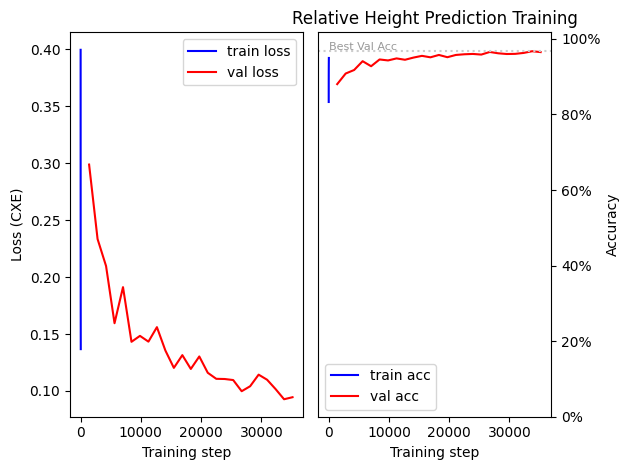

Best Validation Accuracy: 96.73%


In [17]:
'''SECOND TASK: RELATIVE PATCH HEIGHT PREDICTION'''

print('----PRETRAINING ON RELATIVE PATCH HEIGHT PREDICTION TASK----')
# before training your pretext task, be sure to re-initialise the backbone:
backbone_resnet = models.resnet18().to(device)

# and attach it to whatever pretext classifier head you need
pretext_head = RelativePatchHeightHead(input_size=1000, projection_size=256, num_classes=3).to(device)


# combine the two, so that the training function
# optimises over both their parameters:
relative_height_model = RelativeHeightModel(backbone_resnet, pretext_head)

### train on your pretext task here!
self_supervised_relative_height_best_val_acc = train_self_supervised_relative_height(
    model=relative_height_model,
    train_loader=ssl_relative_height_train_loader,
    val_loader=ssl_relative_height_val_loader,
    num_epochs=25,
    lr=1e-4,
    l2_reg=1e-3,
    gamma=1
    )


# after pre-training, save the backbone:
torch.save(backbone_resnet.state_dict(), 'selfsupervised_relative_height_backbone.pt')

----PRETRAINING ON INPAINTING TASK----


Epoch 1/25: 100%|██████████████████████| 1407/1407 [07:50<00:00,  2.99it/s, Loss=0.0678, MSE=0.0678]


----Saved Best Inpainting Model----
Epoch 1/25 | Train Loss: 0.0836, Train MSE: 0.0836 | Val Loss: 0.0782, Val MSE: 0.0782


Epoch 2/25: 100%|██████████████████████| 1407/1407 [05:14<00:00,  4.47it/s, Loss=0.0669, MSE=0.0669]


----Saved Best Inpainting Model----
Epoch 2/25 | Train Loss: 0.0764, Train MSE: 0.0764 | Val Loss: 0.0754, Val MSE: 0.0754


Epoch 3/25: 100%|██████████████████████| 1407/1407 [05:09<00:00,  4.54it/s, Loss=0.0634, MSE=0.0634]


Epoch 3/25 | Train Loss: 0.0750, Train MSE: 0.0750 | Val Loss: 0.0761, Val MSE: 0.0761


Epoch 4/25: 100%|██████████████████████| 1407/1407 [05:08<00:00,  4.56it/s, Loss=0.0713, MSE=0.0713]


Epoch 4/25 | Train Loss: 0.0749, Train MSE: 0.0749 | Val Loss: 0.0758, Val MSE: 0.0758


Epoch 5/25: 100%|██████████████████████| 1407/1407 [05:09<00:00,  4.55it/s, Loss=0.0732, MSE=0.0732]


----Saved Best Inpainting Model----
Epoch 5/25 | Train Loss: 0.0750, Train MSE: 0.0750 | Val Loss: 0.0735, Val MSE: 0.0735


Epoch 6/25: 100%|██████████████████████| 1407/1407 [05:34<00:00,  4.20it/s, Loss=0.0577, MSE=0.0577]


Epoch 6/25 | Train Loss: 0.0753, Train MSE: 0.0753 | Val Loss: 0.0744, Val MSE: 0.0744


Epoch 7/25: 100%|██████████████████████| 1407/1407 [06:43<00:00,  3.49it/s, Loss=0.0904, MSE=0.0904]


Epoch 7/25 | Train Loss: 0.0749, Train MSE: 0.0749 | Val Loss: 0.0799, Val MSE: 0.0799


Epoch 8/25: 100%|██████████████████████| 1407/1407 [06:42<00:00,  3.49it/s, Loss=0.1041, MSE=0.1041]


Epoch 8/25 | Train Loss: 0.0753, Train MSE: 0.0753 | Val Loss: 0.0749, Val MSE: 0.0749


Epoch 9/25: 100%|██████████████████████| 1407/1407 [06:42<00:00,  3.50it/s, Loss=0.0628, MSE=0.0628]


Epoch 9/25 | Train Loss: 0.0745, Train MSE: 0.0745 | Val Loss: 0.0778, Val MSE: 0.0778


Epoch 10/25: 100%|█████████████████████| 1407/1407 [06:43<00:00,  3.49it/s, Loss=0.0796, MSE=0.0796]


Epoch 10/25 | Train Loss: 0.0745, Train MSE: 0.0745 | Val Loss: 0.0742, Val MSE: 0.0742


Epoch 11/25: 100%|█████████████████████| 1407/1407 [06:48<00:00,  3.44it/s, Loss=0.0946, MSE=0.0946]


Epoch 11/25 | Train Loss: 0.0739, Train MSE: 0.0739 | Val Loss: 0.0748, Val MSE: 0.0748


Epoch 12/25: 100%|█████████████████████| 1407/1407 [06:47<00:00,  3.45it/s, Loss=0.0828, MSE=0.0828]


----Saved Best Inpainting Model----
Epoch 12/25 | Train Loss: 0.0744, Train MSE: 0.0744 | Val Loss: 0.0733, Val MSE: 0.0733


Epoch 13/25: 100%|█████████████████████| 1407/1407 [06:48<00:00,  3.45it/s, Loss=0.0821, MSE=0.0821]


Epoch 13/25 | Train Loss: 0.0740, Train MSE: 0.0740 | Val Loss: 0.0767, Val MSE: 0.0767


Epoch 14/25: 100%|█████████████████████| 1407/1407 [06:48<00:00,  3.44it/s, Loss=0.0741, MSE=0.0741]


Epoch 14/25 | Train Loss: 0.0742, Train MSE: 0.0742 | Val Loss: 0.0758, Val MSE: 0.0758


Epoch 15/25: 100%|█████████████████████| 1407/1407 [06:47<00:00,  3.46it/s, Loss=0.0703, MSE=0.0703]


----Saved Best Inpainting Model----
Epoch 15/25 | Train Loss: 0.0736, Train MSE: 0.0736 | Val Loss: 0.0726, Val MSE: 0.0726


Epoch 16/25: 100%|█████████████████████| 1407/1407 [06:48<00:00,  3.44it/s, Loss=0.0779, MSE=0.0779]


Epoch 16/25 | Train Loss: 0.0739, Train MSE: 0.0739 | Val Loss: 0.0739, Val MSE: 0.0739


Epoch 17/25: 100%|█████████████████████| 1407/1407 [06:48<00:00,  3.45it/s, Loss=0.0767, MSE=0.0767]


Epoch 17/25 | Train Loss: 0.0736, Train MSE: 0.0736 | Val Loss: 0.0737, Val MSE: 0.0737


Epoch 18/25: 100%|█████████████████████| 1407/1407 [07:43<00:00,  3.03it/s, Loss=0.0710, MSE=0.0710]


Epoch 18/25 | Train Loss: 0.0734, Train MSE: 0.0734 | Val Loss: 0.0730, Val MSE: 0.0730


Epoch 19/25: 100%|█████████████████████| 1407/1407 [08:01<00:00,  2.92it/s, Loss=0.0960, MSE=0.0960]


----Saved Best Inpainting Model----
Epoch 19/25 | Train Loss: 0.0734, Train MSE: 0.0734 | Val Loss: 0.0719, Val MSE: 0.0719


Epoch 20/25: 100%|█████████████████████| 1407/1407 [08:04<00:00,  2.90it/s, Loss=0.0880, MSE=0.0880]


Epoch 20/25 | Train Loss: 0.0733, Train MSE: 0.0733 | Val Loss: 0.0764, Val MSE: 0.0764


Epoch 21/25: 100%|█████████████████████| 1407/1407 [08:01<00:00,  2.93it/s, Loss=0.0787, MSE=0.0787]


Epoch 21/25 | Train Loss: 0.0731, Train MSE: 0.0731 | Val Loss: 0.0727, Val MSE: 0.0727


Epoch 22/25: 100%|█████████████████████| 1407/1407 [08:03<00:00,  2.91it/s, Loss=0.0731, MSE=0.0731]


Epoch 22/25 | Train Loss: 0.0735, Train MSE: 0.0735 | Val Loss: 0.0743, Val MSE: 0.0743


Epoch 23/25: 100%|█████████████████████| 1407/1407 [08:02<00:00,  2.92it/s, Loss=0.1098, MSE=0.1098]


Epoch 23/25 | Train Loss: 0.0734, Train MSE: 0.0734 | Val Loss: 0.0726, Val MSE: 0.0726


Epoch 24/25: 100%|█████████████████████| 1407/1407 [08:01<00:00,  2.92it/s, Loss=0.0635, MSE=0.0635]


----Saved Best Inpainting Model----
Epoch 24/25 | Train Loss: 0.0730, Train MSE: 0.0730 | Val Loss: 0.0713, Val MSE: 0.0713


Epoch 25/25: 100%|█████████████████████| 1407/1407 [07:55<00:00,  2.96it/s, Loss=0.0821, MSE=0.0821]


Epoch 25/25 | Train Loss: 0.0731, Train MSE: 0.0731 | Val Loss: 0.0715, Val MSE: 0.0715


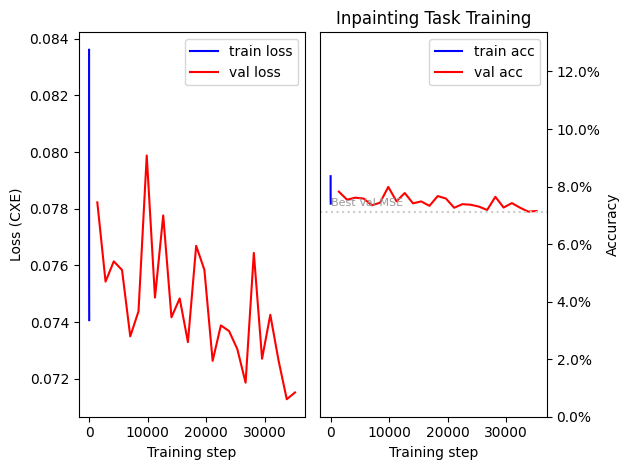

Best Validation MSE: 0.0713


In [24]:

'''THIRD TASK: INPAINTING'''
print('----PRETRAINING ON INPAINTING TASK----')

# before training your pretext task, be sure to re-initialise the backbone:
backbone_resnet = models.resnet18().to(device)

# and attach it to whatever pretext classifier head you need
pretext_head = InpaintingHead(input_size=1000, projection_size=256, output_channels=3, height=96, width=96).to(device)


# combine the two, so that the training function
# optimises over both their parameters:
inpainting_model = InpaintingModel(backbone_resnet, pretext_head).to(device)

#Load the best backbone from the inpainting task if exists
inpainting_model.backbone.load_state_dict(torch.load('selfsupervised_inpainting_best_backbone.pt'))

### train on your pretext task here!
self_supervised_INPAINTING_best_val_MSE = train_self_supervised_inpainting(
    model=inpainting_model,
    train_loader=ssl_inpainting_train_loader,
    val_loader=ssl_inpainting_val_loader,
    num_epochs=25,
    lr=1e-4,
    l2_reg=1e-3,
    gamma=1
)


# after pre-training, save the backbone:
torch.save(backbone_resnet.state_dict(), 'selfsupervised_inpainting_backbone.pt')


## Task 2: Supervised Fine-Tuning

If your model has learned the pretext task well, all that's left is to see how well it works on the downstream task. 

This is just the fine-tuning step in transfer learning, which you're familiar with, so I've written most of the code below. You might need to tweak some hyperparameters depending on your specific pretext task, but this should mostly work as presented.

The hard part is making sure your pretext task, and the self-supervised training loop, works well enough to learn features that help in this downstream classification. See how much you can boost performance over the baseline. (I was able to get 8%!)

### Supervised Fine-Tuning for each of the pretrained models
 Remember that each was pre-trained on a different pretext task (rotation, inpainting, relative height prediction)

#### Supervised Fine-Tuning for Rotation Pretrained Model

E0 loss: 2.18 | acc: 17.3%: 100%|█████████████████████████████████████| 8/8 [00:00<00:00, 31.98it/s]


train loss: 2.27, train acc: 15.1% | val loss: 2.15, val acc: 17.6%


E1 loss: 1.76 | acc: 28.8%: 100%|█████████████████████████████████████| 8/8 [00:00<00:00, 31.94it/s]


train loss: 1.98, train acc: 27.2% | val loss: 1.93, val acc: 25.1%


E2 loss: 1.82 | acc: 21.2%: 100%|█████████████████████████████████████| 8/8 [00:00<00:00, 31.31it/s]


train loss: 1.79, train acc: 31.2% | val loss: 1.79, val acc: 27.8%


E3 loss: 1.54 | acc: 40.4%: 100%|█████████████████████████████████████| 8/8 [00:00<00:00, 31.38it/s]


train loss: 1.63, train acc: 37.5% | val loss: 1.72, val acc: 32.3%


E4 loss: 1.47 | acc: 34.6%: 100%|█████████████████████████████████████| 8/8 [00:00<00:00, 32.05it/s]


train loss: 1.50, train acc: 45.0% | val loss: 1.69, val acc: 33.2%


E5 loss: 1.36 | acc: 44.2%: 100%|█████████████████████████████████████| 8/8 [00:00<00:00, 32.25it/s]


train loss: 1.38, train acc: 45.4% | val loss: 1.64, val acc: 38.0%


E6 loss: 1.19 | acc: 55.8%: 100%|█████████████████████████████████████| 8/8 [00:00<00:00, 31.37it/s]


train loss: 1.23, train acc: 56.4% | val loss: 1.65, val acc: 37.3%


E7 loss: 1.16 | acc: 50.0%: 100%|█████████████████████████████████████| 8/8 [00:00<00:00, 31.46it/s]


train loss: 1.11, train acc: 60.4% | val loss: 1.68, val acc: 36.3%


E8 loss: 0.89 | acc: 75.0%: 100%|█████████████████████████████████████| 8/8 [00:00<00:00, 31.51it/s]


train loss: 0.95, train acc: 65.4% | val loss: 1.71, val acc: 38.2%


E9 loss: 0.82 | acc: 61.5%: 100%|█████████████████████████████████████| 8/8 [00:00<00:00, 31.32it/s]


train loss: 0.85, train acc: 70.8% | val loss: 1.75, val acc: 39.5%


E10 loss: 0.59 | acc: 80.8%: 100%|████████████████████████████████████| 8/8 [00:00<00:00, 31.55it/s]


train loss: 0.70, train acc: 76.3% | val loss: 1.81, val acc: 39.1%


E11 loss: 0.62 | acc: 78.8%: 100%|████████████████████████████████████| 8/8 [00:00<00:00, 31.39it/s]


train loss: 0.61, train acc: 79.2% | val loss: 1.89, val acc: 39.5%


E12 loss: 0.43 | acc: 86.5%: 100%|████████████████████████████████████| 8/8 [00:00<00:00, 31.17it/s]


train loss: 0.54, train acc: 79.0% | val loss: 1.97, val acc: 39.2%


E13 loss: 0.39 | acc: 84.6%: 100%|████████████████████████████████████| 8/8 [00:00<00:00, 31.41it/s]


train loss: 0.45, train acc: 83.4% | val loss: 2.07, val acc: 38.0%


E14 loss: 0.34 | acc: 86.5%: 100%|████████████████████████████████████| 8/8 [00:00<00:00, 31.19it/s]


train loss: 0.41, train acc: 87.2% | val loss: 2.19, val acc: 37.3%


E15 loss: 0.32 | acc: 92.3%: 100%|████████████████████████████████████| 8/8 [00:00<00:00, 31.66it/s]


train loss: 0.34, train acc: 90.1% | val loss: 2.14, val acc: 41.1%


E16 loss: 0.28 | acc: 96.2%: 100%|████████████████████████████████████| 8/8 [00:00<00:00, 31.09it/s]


train loss: 0.32, train acc: 90.9% | val loss: 2.23, val acc: 41.6%


E17 loss: 0.19 | acc: 98.1%: 100%|████████████████████████████████████| 8/8 [00:00<00:00, 31.52it/s]


train loss: 0.25, train acc: 94.3% | val loss: 2.32, val acc: 38.6%


E18 loss: 0.31 | acc: 96.2%: 100%|████████████████████████████████████| 8/8 [00:00<00:00, 31.21it/s]


train loss: 0.22, train acc: 96.8% | val loss: 2.39, val acc: 39.6%


E19 loss: 0.17 | acc: 92.3%: 100%|████████████████████████████████████| 8/8 [00:00<00:00, 31.56it/s]


train loss: 0.20, train acc: 94.5% | val loss: 2.47, val acc: 39.2%


E20 loss: 0.17 | acc: 94.2%: 100%|████████████████████████████████████| 8/8 [00:00<00:00, 31.38it/s]


train loss: 0.16, train acc: 96.5% | val loss: 2.61, val acc: 38.0%


E21 loss: 0.18 | acc: 98.1%: 100%|████████████████████████████████████| 8/8 [00:00<00:00, 31.51it/s]


train loss: 0.14, train acc: 98.2% | val loss: 2.57, val acc: 39.4%


E22 loss: 0.14 | acc: 96.2%: 100%|████████████████████████████████████| 8/8 [00:00<00:00, 30.98it/s]


train loss: 0.17, train acc: 95.8% | val loss: 2.62, val acc: 39.6%


E23 loss: 0.12 | acc: 96.2%: 100%|████████████████████████████████████| 8/8 [00:00<00:00, 31.00it/s]


train loss: 0.14, train acc: 97.4% | val loss: 2.74, val acc: 39.3%


E24 loss: 0.07 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 31.35it/s]


train loss: 0.11, train acc: 98.4% | val loss: 2.87, val acc: 37.7%


E25 loss: 0.06 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 31.72it/s]


train loss: 0.08, train acc: 99.4% | val loss: 2.81, val acc: 40.7%


E26 loss: 0.17 | acc: 94.2%: 100%|████████████████████████████████████| 8/8 [00:00<00:00, 31.71it/s]


train loss: 0.07, train acc: 98.9% | val loss: 2.81, val acc: 41.6%


E27 loss: 0.03 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 32.32it/s]


train loss: 0.04, train acc: 100.0% | val loss: 3.03, val acc: 39.9%


E28 loss: 0.06 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 31.42it/s]


train loss: 0.06, train acc: 99.4% | val loss: 3.00, val acc: 40.0%


E29 loss: 0.06 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 31.04it/s]


train loss: 0.07, train acc: 98.4% | val loss: 3.00, val acc: 40.7%


E30 loss: 0.04 | acc: 98.1%: 100%|████████████████████████████████████| 8/8 [00:00<00:00, 31.55it/s]


train loss: 0.04, train acc: 98.8% | val loss: 3.06, val acc: 40.0%


E31 loss: 0.04 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 31.79it/s]


train loss: 0.03, train acc: 99.8% | val loss: 3.16, val acc: 39.1%


E32 loss: 0.02 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 31.60it/s]


train loss: 0.04, train acc: 99.6% | val loss: 3.25, val acc: 39.2%


E33 loss: 0.04 | acc: 98.1%: 100%|████████████████████████████████████| 8/8 [00:00<00:00, 31.04it/s]


train loss: 0.03, train acc: 99.6% | val loss: 3.29, val acc: 39.3%


E34 loss: 0.02 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 31.59it/s]


train loss: 0.03, train acc: 99.8% | val loss: 3.28, val acc: 38.4%


E35 loss: 0.04 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 31.28it/s]


train loss: 0.02, train acc: 99.6% | val loss: 3.28, val acc: 39.2%


E36 loss: 0.01 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 31.18it/s]


train loss: 0.02, train acc: 99.8% | val loss: 3.17, val acc: 40.3%


E37 loss: 0.01 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 30.30it/s]


train loss: 0.02, train acc: 99.8% | val loss: 3.29, val acc: 39.8%


E38 loss: 0.15 | acc: 94.2%: 100%|████████████████████████████████████| 8/8 [00:00<00:00, 30.88it/s]


train loss: 0.04, train acc: 98.9% | val loss: 3.30, val acc: 39.7%


E39 loss: 0.02 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 32.06it/s]


train loss: 0.02, train acc: 99.6% | val loss: 3.41, val acc: 38.4%


E40 loss: 0.02 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 31.46it/s]


train loss: 0.03, train acc: 99.6% | val loss: 3.47, val acc: 37.7%


E41 loss: 0.02 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 31.54it/s]


train loss: 0.02, train acc: 99.8% | val loss: 3.53, val acc: 39.5%


E42 loss: 0.08 | acc: 98.1%: 100%|████████████████████████████████████| 8/8 [00:00<00:00, 31.91it/s]


train loss: 0.03, train acc: 99.2% | val loss: 3.48, val acc: 39.4%


E43 loss: 0.01 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 31.84it/s]


train loss: 0.04, train acc: 99.4% | val loss: 3.47, val acc: 39.6%


E44 loss: 0.02 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 31.73it/s]


train loss: 0.01, train acc: 100.0% | val loss: 3.49, val acc: 39.5%


E45 loss: 0.01 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 31.83it/s]


train loss: 0.01, train acc: 100.0% | val loss: 3.44, val acc: 40.2%


E46 loss: 0.01 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 31.15it/s]


train loss: 0.01, train acc: 100.0% | val loss: 3.52, val acc: 40.5%


E47 loss: 0.01 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 31.91it/s]


train loss: 0.01, train acc: 100.0% | val loss: 3.57, val acc: 39.3%


E48 loss: 0.02 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 33.19it/s]


train loss: 0.01, train acc: 100.0% | val loss: 3.44, val acc: 40.5%


E49 loss: 0.01 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 33.15it/s]


train loss: 0.01, train acc: 100.0% | val loss: 3.48, val acc: 41.1%


E50 loss: 0.01 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 31.03it/s]


train loss: 0.01, train acc: 100.0% | val loss: 3.55, val acc: 39.8%


E51 loss: 0.01 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 31.20it/s]


train loss: 0.00, train acc: 100.0% | val loss: 3.49, val acc: 40.0%


E52 loss: 0.01 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 31.05it/s]


train loss: 0.01, train acc: 100.0% | val loss: 3.62, val acc: 39.6%


E53 loss: 0.01 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 31.29it/s]


train loss: 0.01, train acc: 100.0% | val loss: 3.54, val acc: 40.5%


E54 loss: 0.01 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 31.73it/s]


train loss: 0.01, train acc: 99.8% | val loss: 3.68, val acc: 37.9%


E55 loss: 0.00 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 31.47it/s]


train loss: 0.01, train acc: 100.0% | val loss: 3.59, val acc: 39.7%


E56 loss: 0.00 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 31.19it/s]


train loss: 0.00, train acc: 100.0% | val loss: 3.60, val acc: 39.3%


E57 loss: 0.00 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 30.93it/s]


train loss: 0.00, train acc: 100.0% | val loss: 3.52, val acc: 40.8%


E58 loss: 0.02 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 31.80it/s]


train loss: 0.00, train acc: 100.0% | val loss: 3.60, val acc: 39.5%


E59 loss: 0.00 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 32.00it/s]


train loss: 0.00, train acc: 100.0% | val loss: 3.59, val acc: 39.6%


E60 loss: 0.02 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 31.91it/s]


train loss: 0.01, train acc: 100.0% | val loss: 3.59, val acc: 39.8%


E61 loss: 0.00 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 32.47it/s]


train loss: 0.01, train acc: 99.8% | val loss: 3.69, val acc: 39.6%


E62 loss: 0.05 | acc: 98.1%: 100%|████████████████████████████████████| 8/8 [00:00<00:00, 32.38it/s]


train loss: 0.01, train acc: 99.8% | val loss: 3.69, val acc: 38.9%


E63 loss: 0.01 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 31.17it/s]


train loss: 0.01, train acc: 99.6% | val loss: 3.73, val acc: 39.3%


E64 loss: 0.00 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 31.24it/s]


train loss: 0.02, train acc: 99.6% | val loss: 3.63, val acc: 41.2%


E65 loss: 0.01 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 31.20it/s]


train loss: 0.02, train acc: 99.4% | val loss: 3.76, val acc: 40.4%


E66 loss: 0.01 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 31.76it/s]


train loss: 0.02, train acc: 99.8% | val loss: 3.76, val acc: 40.1%


E67 loss: 0.01 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 31.70it/s]


train loss: 0.05, train acc: 98.4% | val loss: 3.89, val acc: 39.0%


E68 loss: 0.01 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 31.71it/s]


train loss: 0.09, train acc: 97.3% | val loss: 3.85, val acc: 39.6%


E69 loss: 0.32 | acc: 90.4%: 100%|████████████████████████████████████| 8/8 [00:00<00:00, 31.75it/s]


train loss: 0.14, train acc: 95.9% | val loss: 3.75, val acc: 40.0%


E70 loss: 0.07 | acc: 96.2%: 100%|████████████████████████████████████| 8/8 [00:00<00:00, 31.37it/s]


train loss: 0.10, train acc: 96.6% | val loss: 3.70, val acc: 40.9%


E71 loss: 0.18 | acc: 96.2%: 100%|████████████████████████████████████| 8/8 [00:00<00:00, 31.08it/s]


train loss: 0.14, train acc: 96.2% | val loss: 3.54, val acc: 42.7%


E72 loss: 0.31 | acc: 92.3%: 100%|████████████████████████████████████| 8/8 [00:00<00:00, 31.77it/s]


train loss: 0.17, train acc: 94.9% | val loss: 4.48, val acc: 36.3%


E73 loss: 0.04 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 31.47it/s]


train loss: 0.09, train acc: 96.9% | val loss: 3.41, val acc: 40.6%


E74 loss: 0.12 | acc: 96.2%: 100%|████████████████████████████████████| 8/8 [00:00<00:00, 31.41it/s]


train loss: 0.08, train acc: 97.6% | val loss: 3.18, val acc: 43.9%


E75 loss: 0.05 | acc: 98.1%: 100%|████████████████████████████████████| 8/8 [00:00<00:00, 30.77it/s]


train loss: 0.03, train acc: 99.2% | val loss: 3.38, val acc: 42.1%


E76 loss: 0.05 | acc: 98.1%: 100%|████████████████████████████████████| 8/8 [00:00<00:00, 31.24it/s]


train loss: 0.04, train acc: 99.4% | val loss: 3.31, val acc: 42.9%


E77 loss: 0.06 | acc: 98.1%: 100%|████████████████████████████████████| 8/8 [00:00<00:00, 30.89it/s]


train loss: 0.04, train acc: 99.4% | val loss: 3.20, val acc: 43.8%


E78 loss: 0.07 | acc: 98.1%: 100%|████████████████████████████████████| 8/8 [00:00<00:00, 30.73it/s]


train loss: 0.04, train acc: 98.8% | val loss: 3.26, val acc: 43.4%


E79 loss: 0.02 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 31.08it/s]


train loss: 0.01, train acc: 99.8% | val loss: 3.11, val acc: 44.1%


E80 loss: 0.01 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 31.00it/s]


train loss: 0.02, train acc: 99.6% | val loss: 3.24, val acc: 44.6%


E81 loss: 0.01 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 31.24it/s]


train loss: 0.01, train acc: 99.6% | val loss: 3.21, val acc: 45.9%


E82 loss: 0.01 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 31.66it/s]


train loss: 0.01, train acc: 99.8% | val loss: 3.28, val acc: 44.4%


E83 loss: 0.01 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 31.27it/s]


train loss: 0.01, train acc: 99.8% | val loss: 3.21, val acc: 44.5%


E84 loss: 0.01 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 31.15it/s]


train loss: 0.01, train acc: 99.8% | val loss: 3.26, val acc: 44.2%


E85 loss: 0.02 | acc: 98.1%: 100%|████████████████████████████████████| 8/8 [00:00<00:00, 31.48it/s]


train loss: 0.01, train acc: 99.8% | val loss: 3.25, val acc: 44.4%


E86 loss: 0.02 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 31.24it/s]


train loss: 0.01, train acc: 100.0% | val loss: 3.13, val acc: 44.3%


E87 loss: 0.00 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 31.31it/s]


train loss: 0.00, train acc: 100.0% | val loss: 3.22, val acc: 45.1%


E88 loss: 0.02 | acc: 98.1%: 100%|████████████████████████████████████| 8/8 [00:00<00:00, 31.52it/s]


train loss: 0.01, train acc: 99.8% | val loss: 3.44, val acc: 44.5%


E89 loss: 0.00 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 31.08it/s]


train loss: 0.00, train acc: 100.0% | val loss: 3.29, val acc: 44.7%


E90 loss: 0.00 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 31.53it/s]


train loss: 0.00, train acc: 100.0% | val loss: 3.28, val acc: 46.2%


E91 loss: 0.00 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 31.41it/s]


train loss: 0.00, train acc: 100.0% | val loss: 3.30, val acc: 45.8%


E92 loss: 0.00 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 31.43it/s]


train loss: 0.00, train acc: 100.0% | val loss: 3.32, val acc: 43.9%


E93 loss: 0.00 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 31.61it/s]


train loss: 0.00, train acc: 100.0% | val loss: 3.28, val acc: 46.1%


E94 loss: 0.00 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 31.69it/s]


train loss: 0.00, train acc: 100.0% | val loss: 3.32, val acc: 45.4%


E95 loss: 0.00 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 31.20it/s]


train loss: 0.00, train acc: 100.0% | val loss: 3.26, val acc: 45.5%


E96 loss: 0.00 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 31.23it/s]


train loss: 0.00, train acc: 100.0% | val loss: 3.27, val acc: 44.8%


E97 loss: 0.00 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 31.50it/s]


train loss: 0.00, train acc: 100.0% | val loss: 3.22, val acc: 45.0%


E98 loss: 0.00 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 31.19it/s]


train loss: 0.00, train acc: 100.0% | val loss: 3.26, val acc: 45.4%


E99 loss: 0.00 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 31.45it/s]


train loss: 0.00, train acc: 100.0% | val loss: 3.21, val acc: 44.6%


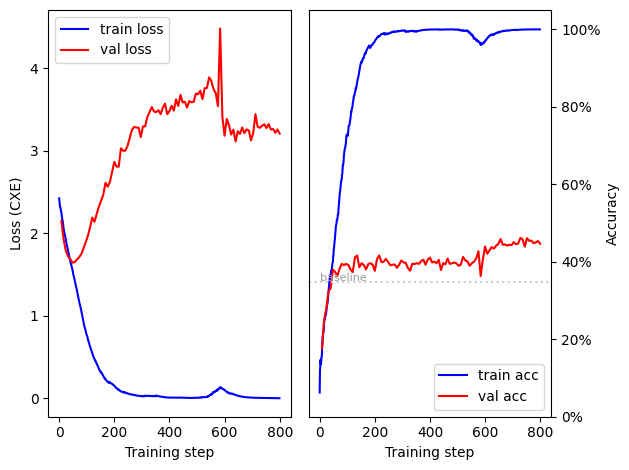

Best validation accuracy: 46.17%
----Fine-Tuning Completed. Validation Accuracy: 46.17%----


In [22]:
# re-load the backbone with saved weights from self-supervised training:
selfsup_rotation_backbone = models.resnet18().to(device)
selfsup_rotation_backbone.load_state_dict(torch.load('selfsupervised_rotation_backbone.pt', weights_only=True))

# optionally, try freezing the backbone to avoid overfitting:
FREEZE_BACKBONE = True
layers_to_freeze = [selfsup_rotation_backbone.layer1,
          selfsup_rotation_backbone.layer2,
          selfsup_rotation_backbone.layer3,
          # selfsup_backbone.layer4,
         ]

if FREEZE_BACKBONE:
    for layer in layers_to_freeze:
        for param in layer:
            param.requires_grad = False

# re-initialise the baseline classifier head, but attach it to the self-supervised backbone:
classification_head = ClassifierHead(input_size=1000, projection_size=256, num_classes=10, dropout=0.5).to(device)
selfsup_model = nn.Sequential(selfsup_rotation_backbone, classification_head)

# fine-tune:
num_epochs = 100
lr = 1e-4 
l2_reg = 1e-3

ft_acc = train_supervised(selfsup_model, train_loader, val_loader, 
                           num_epochs, lr, l2_reg, baselines={'baseline': baseline_acc})
print(f'----Fine-Tuning Completed. Validation Accuracy: {ft_acc*100:.2f}%----')

#### Supervised Fine-Tuning for Relative Height Prediction Pretrained Model

----FINE-TUNING RELATIVE HEIGHT PRETRAINED MODEL----
----Backbone layers frozen----


E0 loss: 2.28 | acc: 11.5%: 100%|█████████████████████████████████████| 8/8 [00:00<00:00, 36.24it/s]


train loss: 2.30, train acc: 9.6% | val loss: 2.27, val acc: 12.9%


E1 loss: 2.24 | acc: 21.2%: 100%|█████████████████████████████████████| 8/8 [00:00<00:00, 36.60it/s]


train loss: 2.25, train acc: 20.8% | val loss: 2.22, val acc: 18.1%


E2 loss: 2.21 | acc: 23.1%: 100%|█████████████████████████████████████| 8/8 [00:00<00:00, 36.77it/s]


train loss: 2.20, train acc: 22.4% | val loss: 2.15, val acc: 21.3%


E3 loss: 2.13 | acc: 23.1%: 100%|█████████████████████████████████████| 8/8 [00:00<00:00, 36.66it/s]


train loss: 2.13, train acc: 26.5% | val loss: 2.07, val acc: 23.3%


E4 loss: 2.01 | acc: 26.9%: 100%|█████████████████████████████████████| 8/8 [00:00<00:00, 37.07it/s]


train loss: 2.05, train acc: 28.8% | val loss: 2.01, val acc: 26.8%


E5 loss: 1.87 | acc: 38.5%: 100%|█████████████████████████████████████| 8/8 [00:00<00:00, 37.35it/s]


train loss: 1.96, train acc: 31.0% | val loss: 1.96, val acc: 29.6%


E6 loss: 1.92 | acc: 23.1%: 100%|█████████████████████████████████████| 8/8 [00:00<00:00, 36.74it/s]


train loss: 1.87, train acc: 34.1% | val loss: 1.92, val acc: 30.4%


E7 loss: 1.76 | acc: 32.7%: 100%|█████████████████████████████████████| 8/8 [00:00<00:00, 37.44it/s]


train loss: 1.77, train acc: 34.8% | val loss: 1.83, val acc: 33.0%


E8 loss: 1.72 | acc: 44.2%: 100%|█████████████████████████████████████| 8/8 [00:00<00:00, 37.33it/s]


train loss: 1.70, train acc: 39.1% | val loss: 1.79, val acc: 34.2%


E9 loss: 1.47 | acc: 44.2%: 100%|█████████████████████████████████████| 8/8 [00:00<00:00, 37.84it/s]


train loss: 1.63, train acc: 41.7% | val loss: 1.73, val acc: 36.0%


E10 loss: 1.46 | acc: 48.1%: 100%|████████████████████████████████████| 8/8 [00:00<00:00, 37.52it/s]


train loss: 1.54, train acc: 42.1% | val loss: 1.71, val acc: 35.1%


E11 loss: 1.40 | acc: 50.0%: 100%|████████████████████████████████████| 8/8 [00:00<00:00, 37.32it/s]


train loss: 1.46, train acc: 46.9% | val loss: 1.67, val acc: 36.2%


E12 loss: 1.32 | acc: 53.8%: 100%|████████████████████████████████████| 8/8 [00:00<00:00, 37.43it/s]


train loss: 1.39, train acc: 48.5% | val loss: 1.65, val acc: 37.3%


E13 loss: 1.23 | acc: 55.8%: 100%|████████████████████████████████████| 8/8 [00:00<00:00, 37.60it/s]


train loss: 1.33, train acc: 51.9% | val loss: 1.66, val acc: 35.7%


E14 loss: 1.20 | acc: 57.7%: 100%|████████████████████████████████████| 8/8 [00:00<00:00, 37.05it/s]


train loss: 1.28, train acc: 52.9% | val loss: 1.60, val acc: 38.8%


E15 loss: 1.14 | acc: 67.3%: 100%|████████████████████████████████████| 8/8 [00:00<00:00, 36.90it/s]


train loss: 1.20, train acc: 59.8% | val loss: 1.63, val acc: 38.2%


E16 loss: 1.18 | acc: 48.1%: 100%|████████████████████████████████████| 8/8 [00:00<00:00, 36.49it/s]


train loss: 1.14, train acc: 59.9% | val loss: 1.67, val acc: 35.5%


E17 loss: 1.12 | acc: 59.6%: 100%|████████████████████████████████████| 8/8 [00:00<00:00, 36.84it/s]


train loss: 1.03, train acc: 64.1% | val loss: 1.61, val acc: 39.0%


E18 loss: 0.87 | acc: 59.6%: 100%|████████████████████████████████████| 8/8 [00:00<00:00, 36.82it/s]


train loss: 0.96, train acc: 67.4% | val loss: 1.64, val acc: 40.0%


E19 loss: 0.82 | acc: 73.1%: 100%|████████████████████████████████████| 8/8 [00:00<00:00, 36.30it/s]


train loss: 0.88, train acc: 70.9% | val loss: 1.77, val acc: 34.9%


E20 loss: 0.84 | acc: 75.0%: 100%|████████████████████████████████████| 8/8 [00:00<00:00, 37.13it/s]


train loss: 0.79, train acc: 74.8% | val loss: 1.70, val acc: 40.1%


E21 loss: 0.76 | acc: 73.1%: 100%|████████████████████████████████████| 8/8 [00:00<00:00, 37.03it/s]


train loss: 0.70, train acc: 79.6% | val loss: 1.73, val acc: 39.9%


E22 loss: 0.62 | acc: 80.8%: 100%|████████████████████████████████████| 8/8 [00:00<00:00, 37.14it/s]


train loss: 0.65, train acc: 81.4% | val loss: 1.83, val acc: 38.9%


E23 loss: 0.53 | acc: 88.5%: 100%|████████████████████████████████████| 8/8 [00:00<00:00, 36.82it/s]


train loss: 0.57, train acc: 86.3% | val loss: 1.81, val acc: 39.9%


E24 loss: 0.55 | acc: 86.5%: 100%|████████████████████████████████████| 8/8 [00:00<00:00, 36.98it/s]


train loss: 0.50, train acc: 87.8% | val loss: 1.94, val acc: 39.9%


E25 loss: 0.43 | acc: 88.5%: 100%|████████████████████████████████████| 8/8 [00:00<00:00, 36.67it/s]


train loss: 0.48, train acc: 87.4% | val loss: 1.93, val acc: 39.1%


E26 loss: 0.38 | acc: 92.3%: 100%|████████████████████████████████████| 8/8 [00:00<00:00, 36.67it/s]


train loss: 0.39, train acc: 93.2% | val loss: 2.08, val acc: 39.8%


E27 loss: 0.26 | acc: 98.1%: 100%|████████████████████████████████████| 8/8 [00:00<00:00, 36.74it/s]


train loss: 0.33, train acc: 94.9% | val loss: 2.06, val acc: 39.4%


E28 loss: 0.36 | acc: 90.4%: 100%|████████████████████████████████████| 8/8 [00:00<00:00, 36.87it/s]


train loss: 0.29, train acc: 96.6% | val loss: 2.14, val acc: 39.5%


E29 loss: 0.24 | acc: 98.1%: 100%|████████████████████████████████████| 8/8 [00:00<00:00, 36.74it/s]


train loss: 0.23, train acc: 97.6% | val loss: 2.21, val acc: 37.1%


E30 loss: 0.21 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 36.76it/s]


train loss: 0.19, train acc: 99.4% | val loss: 2.18, val acc: 40.6%


E31 loss: 0.16 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 36.11it/s]


train loss: 0.19, train acc: 98.0% | val loss: 2.41, val acc: 38.7%


E32 loss: 0.17 | acc: 96.2%: 100%|████████████████████████████████████| 8/8 [00:00<00:00, 37.45it/s]


train loss: 0.21, train acc: 94.8% | val loss: 2.45, val acc: 38.0%


E33 loss: 0.24 | acc: 94.2%: 100%|████████████████████████████████████| 8/8 [00:00<00:00, 37.04it/s]


train loss: 0.19, train acc: 96.5% | val loss: 2.50, val acc: 37.9%


E34 loss: 0.15 | acc: 98.1%: 100%|████████████████████████████████████| 8/8 [00:00<00:00, 37.19it/s]


train loss: 0.20, train acc: 94.5% | val loss: 2.53, val acc: 39.3%


E35 loss: 0.21 | acc: 96.2%: 100%|████████████████████████████████████| 8/8 [00:00<00:00, 37.31it/s]


train loss: 0.20, train acc: 96.2% | val loss: 2.79, val acc: 34.6%


E36 loss: 0.13 | acc: 98.1%: 100%|████████████████████████████████████| 8/8 [00:00<00:00, 36.88it/s]


train loss: 0.15, train acc: 98.0% | val loss: 2.72, val acc: 38.3%


E37 loss: 0.12 | acc: 98.1%: 100%|████████████████████████████████████| 8/8 [00:00<00:00, 37.19it/s]


train loss: 0.15, train acc: 96.6% | val loss: 2.72, val acc: 36.7%


E38 loss: 0.09 | acc: 98.1%: 100%|████████████████████████████████████| 8/8 [00:00<00:00, 36.92it/s]


train loss: 0.09, train acc: 98.8% | val loss: 2.78, val acc: 39.8%


E39 loss: 0.07 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 36.83it/s]


train loss: 0.08, train acc: 99.0% | val loss: 2.80, val acc: 38.5%


E40 loss: 0.07 | acc: 98.1%: 100%|████████████████████████████████████| 8/8 [00:00<00:00, 37.07it/s]


train loss: 0.07, train acc: 99.8% | val loss: 2.77, val acc: 39.9%


E41 loss: 0.08 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 36.88it/s]


train loss: 0.08, train acc: 99.2% | val loss: 2.88, val acc: 37.5%


E42 loss: 0.10 | acc: 96.2%: 100%|████████████████████████████████████| 8/8 [00:00<00:00, 36.92it/s]


train loss: 0.06, train acc: 99.1% | val loss: 2.80, val acc: 39.5%


E43 loss: 0.07 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 37.19it/s]


train loss: 0.06, train acc: 99.8% | val loss: 2.88, val acc: 39.3%


E44 loss: 0.06 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 36.19it/s]


train loss: 0.04, train acc: 100.0% | val loss: 2.90, val acc: 38.8%


E45 loss: 0.03 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 35.74it/s]


train loss: 0.03, train acc: 100.0% | val loss: 2.86, val acc: 40.6%


E46 loss: 0.04 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 36.03it/s]


train loss: 0.03, train acc: 100.0% | val loss: 2.86, val acc: 40.5%


E47 loss: 0.04 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 36.82it/s]


train loss: 0.03, train acc: 100.0% | val loss: 2.89, val acc: 40.4%


E48 loss: 0.05 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 36.68it/s]


train loss: 0.03, train acc: 100.0% | val loss: 2.97, val acc: 40.4%


E49 loss: 0.03 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 36.46it/s]


train loss: 0.03, train acc: 100.0% | val loss: 2.98, val acc: 40.4%


E50 loss: 0.03 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 37.16it/s]


train loss: 0.03, train acc: 100.0% | val loss: 2.99, val acc: 40.5%


E51 loss: 0.02 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 36.88it/s]


train loss: 0.02, train acc: 100.0% | val loss: 3.00, val acc: 40.0%


E52 loss: 0.07 | acc: 98.1%: 100%|████████████████████████████████████| 8/8 [00:00<00:00, 37.89it/s]


train loss: 0.04, train acc: 99.4% | val loss: 3.08, val acc: 40.6%


E53 loss: 0.02 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 37.88it/s]


train loss: 0.02, train acc: 100.0% | val loss: 3.06, val acc: 40.1%


E54 loss: 0.01 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 36.24it/s]


train loss: 0.03, train acc: 99.8% | val loss: 3.12, val acc: 38.6%


E55 loss: 0.03 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 36.67it/s]


train loss: 0.02, train acc: 100.0% | val loss: 3.11, val acc: 39.9%


E56 loss: 0.01 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 37.23it/s]


train loss: 0.02, train acc: 100.0% | val loss: 3.11, val acc: 40.0%


E57 loss: 0.02 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 37.63it/s]


train loss: 0.02, train acc: 100.0% | val loss: 3.07, val acc: 40.7%


E58 loss: 0.02 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 37.48it/s]


train loss: 0.01, train acc: 100.0% | val loss: 3.10, val acc: 40.2%


E59 loss: 0.03 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 37.70it/s]


train loss: 0.02, train acc: 100.0% | val loss: 3.14, val acc: 39.8%


E60 loss: 0.01 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 37.75it/s]


train loss: 0.02, train acc: 100.0% | val loss: 3.12, val acc: 39.8%


E61 loss: 0.01 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 36.81it/s]


train loss: 0.02, train acc: 100.0% | val loss: 3.18, val acc: 39.4%


E62 loss: 0.01 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 37.11it/s]


train loss: 0.01, train acc: 100.0% | val loss: 3.17, val acc: 39.9%


E63 loss: 0.01 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 37.69it/s]


train loss: 0.01, train acc: 100.0% | val loss: 3.21, val acc: 39.9%


E64 loss: 0.01 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 36.31it/s]


train loss: 0.01, train acc: 100.0% | val loss: 3.26, val acc: 39.7%


E65 loss: 0.01 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 37.02it/s]


train loss: 0.01, train acc: 100.0% | val loss: 3.15, val acc: 41.7%


E66 loss: 0.01 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 37.78it/s]


train loss: 0.01, train acc: 100.0% | val loss: 3.20, val acc: 40.9%


E67 loss: 0.02 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 36.14it/s]


train loss: 0.01, train acc: 100.0% | val loss: 3.26, val acc: 39.9%


E68 loss: 0.01 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 37.73it/s]


train loss: 0.01, train acc: 100.0% | val loss: 3.16, val acc: 41.5%


E69 loss: 0.01 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 37.85it/s]


train loss: 0.01, train acc: 100.0% | val loss: 3.17, val acc: 42.0%


E70 loss: 0.01 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 37.52it/s]


train loss: 0.01, train acc: 100.0% | val loss: 3.24, val acc: 41.2%


E71 loss: 0.01 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 36.82it/s]


train loss: 0.01, train acc: 100.0% | val loss: 3.32, val acc: 40.7%


E72 loss: 0.01 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 37.01it/s]


train loss: 0.01, train acc: 100.0% | val loss: 3.33, val acc: 40.0%


E73 loss: 0.01 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 37.07it/s]


train loss: 0.01, train acc: 100.0% | val loss: 3.21, val acc: 40.6%


E74 loss: 0.01 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 37.84it/s]


train loss: 0.01, train acc: 100.0% | val loss: 3.34, val acc: 39.8%


E75 loss: 0.02 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 37.72it/s]


train loss: 0.01, train acc: 100.0% | val loss: 3.31, val acc: 39.8%


E76 loss: 0.01 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 37.72it/s]


train loss: 0.01, train acc: 100.0% | val loss: 3.24, val acc: 40.4%


E77 loss: 0.01 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 37.81it/s]


train loss: 0.01, train acc: 100.0% | val loss: 3.36, val acc: 39.1%


E78 loss: 0.02 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 38.06it/s]


train loss: 0.01, train acc: 100.0% | val loss: 3.31, val acc: 39.6%


E79 loss: 0.01 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 37.67it/s]


train loss: 0.01, train acc: 100.0% | val loss: 3.40, val acc: 38.0%


E80 loss: 0.01 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 37.95it/s]


train loss: 0.01, train acc: 100.0% | val loss: 3.32, val acc: 39.5%


E81 loss: 0.03 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 37.80it/s]


train loss: 0.01, train acc: 100.0% | val loss: 3.26, val acc: 40.7%


E82 loss: 0.01 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 37.70it/s]


train loss: 0.01, train acc: 100.0% | val loss: 3.29, val acc: 39.9%


E83 loss: 0.01 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 37.69it/s]


train loss: 0.01, train acc: 100.0% | val loss: 3.31, val acc: 41.0%


E84 loss: 0.01 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 36.25it/s]


train loss: 0.01, train acc: 100.0% | val loss: 3.33, val acc: 40.2%


E85 loss: 0.01 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 36.56it/s]


train loss: 0.01, train acc: 100.0% | val loss: 3.33, val acc: 40.7%


E86 loss: 0.01 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 37.26it/s]


train loss: 0.01, train acc: 100.0% | val loss: 3.38, val acc: 40.8%


E87 loss: 0.01 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 38.00it/s]


train loss: 0.01, train acc: 100.0% | val loss: 3.47, val acc: 39.1%


E88 loss: 0.02 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 38.52it/s]


train loss: 0.01, train acc: 100.0% | val loss: 3.36, val acc: 39.7%


E89 loss: 0.01 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 38.78it/s]


train loss: 0.01, train acc: 100.0% | val loss: 3.31, val acc: 39.8%


E90 loss: 0.01 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 38.34it/s]


train loss: 0.01, train acc: 100.0% | val loss: 3.32, val acc: 40.0%


E91 loss: 0.00 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 38.47it/s]


train loss: 0.01, train acc: 100.0% | val loss: 3.27, val acc: 41.2%


E92 loss: 0.00 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 38.75it/s]


train loss: 0.01, train acc: 100.0% | val loss: 3.36, val acc: 40.1%


E93 loss: 0.01 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 38.14it/s]


train loss: 0.01, train acc: 100.0% | val loss: 3.33, val acc: 40.3%


E94 loss: 0.01 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 37.55it/s]


train loss: 0.01, train acc: 100.0% | val loss: 3.44, val acc: 39.2%


E95 loss: 0.00 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 36.55it/s]


train loss: 0.01, train acc: 100.0% | val loss: 3.30, val acc: 40.7%


E96 loss: 0.00 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 37.19it/s]


train loss: 0.01, train acc: 100.0% | val loss: 3.38, val acc: 40.2%


E97 loss: 0.02 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 37.81it/s]


train loss: 0.01, train acc: 100.0% | val loss: 3.37, val acc: 39.1%


E98 loss: 0.01 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 38.08it/s]


train loss: 0.01, train acc: 100.0% | val loss: 3.33, val acc: 40.2%


E99 loss: 0.00 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 36.93it/s]


train loss: 0.01, train acc: 100.0% | val loss: 3.42, val acc: 39.6%


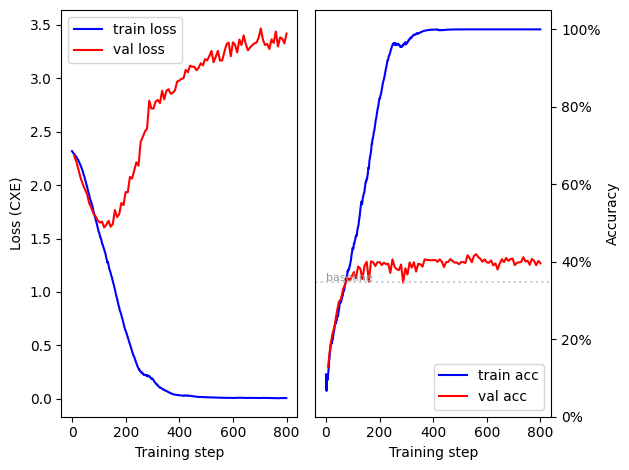

Best validation accuracy: 41.95%
----Fine-Tuning Completed. Validation Accuracy: 41.95%----


In [23]:
print('----FINE-TUNING RELATIVE HEIGHT PRETRAINED MODEL----')

# Re-initialize the backbone and load pretrained weights
selfsup_relative_height_backbone = models.resnet18().to(device)
selfsup_relative_height_backbone.load_state_dict(torch.load('selfsupervised_relative_height_best_backbone.pt'))

# Optionally, freeze certain layers to prevent overfitting
FREEZE_BACKBONE = True
layers_to_freeze = [
    selfsup_relative_height_backbone.layer1,
    selfsup_relative_height_backbone.layer2,
    selfsup_relative_height_backbone.layer3,
    # selfsup_relative_height_backbone.layer4,  # Uncomment to freeze more layers
]

if FREEZE_BACKBONE:
    for layer in layers_to_freeze:
        for param in layer.parameters():
            param.requires_grad = False
    print('----Backbone layers frozen----')
else:
    print('----Backbone layers are trainable----')

# Define the classification head
classification_head = ClassifierHead(input_size=1000, projection_size=256, num_classes=10, dropout=0.5).to(device)

# Combine the frozen backbone and classification head into a supervised model
# Since the backbone is an `nn.Module`, not part of `nn.Sequential`, define a new model class
class FineTunedRelativeHeightModel(nn.Module):
    def __init__(self, backbone, head):
        super(FineTunedRelativeHeightModel, self).__init__()
        self.backbone = backbone
        self.head = head
    
    def forward(self, x):
        features = self.backbone(x)
        out = self.head(features)
        return out

# Instantiate the fine-tuned model
fine_tuned_model = FineTunedRelativeHeightModel(selfsup_relative_height_backbone, classification_head).to(device)

# Define fine-tuning hyperparameters
ft_num_epochs = 100
ft_lr = 1e-4
ft_l2_reg = 1e-3

# Fine-tune the model on the supervised classification task
ft_acc = train_supervised(
    model=fine_tuned_model,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=ft_num_epochs,
    lr=ft_lr,
    l2_reg=ft_l2_reg,
    baselines={'baseline': baseline_acc}
)

print(f'----Fine-Tuning Completed. Validation Accuracy: {ft_acc*100:.2f}%----')


#### Supervised Fine-Tuning for Inpainting Pretrained Model

----Backbone layers frozen----


E0 loss: 2.19 | acc: 23.1%: 100%|█████████████████████████████████████| 8/8 [00:00<00:00, 36.76it/s]


train loss: 2.26, train acc: 17.9% | val loss: 2.17, val acc: 12.9%


E1 loss: 2.02 | acc: 25.0%: 100%|█████████████████████████████████████| 8/8 [00:00<00:00, 37.35it/s]


train loss: 2.07, train acc: 29.9% | val loss: 2.01, val acc: 23.1%


E2 loss: 1.77 | acc: 40.4%: 100%|█████████████████████████████████████| 8/8 [00:00<00:00, 36.96it/s]


train loss: 1.86, train acc: 34.0% | val loss: 1.91, val acc: 30.9%


E3 loss: 1.57 | acc: 42.3%: 100%|█████████████████████████████████████| 8/8 [00:00<00:00, 36.83it/s]


train loss: 1.67, train acc: 41.2% | val loss: 1.79, val acc: 32.8%


E4 loss: 1.46 | acc: 50.0%: 100%|█████████████████████████████████████| 8/8 [00:00<00:00, 36.90it/s]


train loss: 1.48, train acc: 49.0% | val loss: 1.76, val acc: 33.4%


E5 loss: 1.37 | acc: 40.4%: 100%|█████████████████████████████████████| 8/8 [00:00<00:00, 36.83it/s]


train loss: 1.30, train acc: 53.7% | val loss: 1.70, val acc: 35.0%


E6 loss: 1.16 | acc: 61.5%: 100%|█████████████████████████████████████| 8/8 [00:00<00:00, 36.38it/s]


train loss: 1.12, train acc: 64.9% | val loss: 1.67, val acc: 38.0%


E7 loss: 1.03 | acc: 65.4%: 100%|█████████████████████████████████████| 8/8 [00:00<00:00, 37.66it/s]


train loss: 0.95, train acc: 72.0% | val loss: 1.78, val acc: 34.8%


E8 loss: 0.76 | acc: 73.1%: 100%|█████████████████████████████████████| 8/8 [00:00<00:00, 37.46it/s]


train loss: 0.76, train acc: 78.3% | val loss: 1.80, val acc: 36.1%


E9 loss: 0.55 | acc: 82.7%: 100%|█████████████████████████████████████| 8/8 [00:00<00:00, 37.75it/s]


train loss: 0.58, train acc: 84.6% | val loss: 1.88, val acc: 36.3%


E10 loss: 0.42 | acc: 92.3%: 100%|████████████████████████████████████| 8/8 [00:00<00:00, 37.69it/s]


train loss: 0.43, train acc: 90.1% | val loss: 2.08, val acc: 36.8%


E11 loss: 0.35 | acc: 90.4%: 100%|████████████████████████████████████| 8/8 [00:00<00:00, 37.19it/s]


train loss: 0.34, train acc: 92.4% | val loss: 2.35, val acc: 33.5%


E12 loss: 0.21 | acc: 96.2%: 100%|████████████████████████████████████| 8/8 [00:00<00:00, 37.19it/s]


train loss: 0.23, train acc: 95.2% | val loss: 2.32, val acc: 35.5%


E13 loss: 0.19 | acc: 98.1%: 100%|████████████████████████████████████| 8/8 [00:00<00:00, 37.36it/s]


train loss: 0.16, train acc: 97.2% | val loss: 2.23, val acc: 36.2%


E14 loss: 0.15 | acc: 98.1%: 100%|████████████████████████████████████| 8/8 [00:00<00:00, 36.85it/s]


train loss: 0.11, train acc: 98.8% | val loss: 2.42, val acc: 35.8%


E15 loss: 0.11 | acc: 98.1%: 100%|████████████████████████████████████| 8/8 [00:00<00:00, 38.18it/s]


train loss: 0.09, train acc: 98.2% | val loss: 2.46, val acc: 35.4%


E16 loss: 0.07 | acc: 98.1%: 100%|████████████████████████████████████| 8/8 [00:00<00:00, 37.38it/s]


train loss: 0.07, train acc: 99.0% | val loss: 2.49, val acc: 35.5%


E17 loss: 0.04 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 36.90it/s]


train loss: 0.07, train acc: 99.0% | val loss: 2.68, val acc: 35.7%


E18 loss: 0.03 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 35.71it/s]


train loss: 0.06, train acc: 99.2% | val loss: 2.69, val acc: 36.7%


E19 loss: 0.08 | acc: 98.1%: 100%|████████████████████████████████████| 8/8 [00:00<00:00, 36.51it/s]


train loss: 0.06, train acc: 98.8% | val loss: 2.62, val acc: 35.6%


E20 loss: 0.05 | acc: 98.1%: 100%|████████████████████████████████████| 8/8 [00:00<00:00, 36.62it/s]


train loss: 0.04, train acc: 99.2% | val loss: 2.72, val acc: 35.4%


E21 loss: 0.26 | acc: 92.3%: 100%|████████████████████████████████████| 8/8 [00:00<00:00, 36.61it/s]


train loss: 0.07, train acc: 98.6% | val loss: 2.78, val acc: 36.1%


E22 loss: 0.07 | acc: 98.1%: 100%|████████████████████████████████████| 8/8 [00:00<00:00, 36.60it/s]


train loss: 0.05, train acc: 99.0% | val loss: 2.90, val acc: 36.8%


E23 loss: 0.03 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 36.89it/s]


train loss: 0.04, train acc: 99.2% | val loss: 2.67, val acc: 37.1%


E24 loss: 0.03 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 36.25it/s]


train loss: 0.03, train acc: 99.6% | val loss: 2.79, val acc: 36.2%


E25 loss: 0.02 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 36.32it/s]


train loss: 0.02, train acc: 99.4% | val loss: 2.79, val acc: 36.1%


E26 loss: 0.03 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 36.13it/s]


train loss: 0.02, train acc: 99.8% | val loss: 2.80, val acc: 37.1%


E27 loss: 0.01 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 36.16it/s]


train loss: 0.02, train acc: 99.8% | val loss: 2.83, val acc: 37.1%


E28 loss: 0.02 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 36.43it/s]


train loss: 0.02, train acc: 99.6% | val loss: 2.89, val acc: 36.5%


E29 loss: 0.02 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 36.43it/s]


train loss: 0.01, train acc: 100.0% | val loss: 2.80, val acc: 37.0%


E30 loss: 0.01 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 35.45it/s]


train loss: 0.01, train acc: 100.0% | val loss: 2.80, val acc: 37.8%


E31 loss: 0.01 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 36.71it/s]


train loss: 0.01, train acc: 100.0% | val loss: 2.80, val acc: 35.2%


E32 loss: 0.00 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 36.53it/s]


train loss: 0.01, train acc: 100.0% | val loss: 2.73, val acc: 38.2%


E33 loss: 0.01 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 36.76it/s]


train loss: 0.01, train acc: 100.0% | val loss: 2.88, val acc: 36.3%


E34 loss: 0.01 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 36.72it/s]


train loss: 0.01, train acc: 100.0% | val loss: 2.84, val acc: 36.6%


E35 loss: 0.00 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 36.64it/s]


train loss: 0.00, train acc: 100.0% | val loss: 2.81, val acc: 37.0%


E36 loss: 0.00 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 35.86it/s]


train loss: 0.00, train acc: 100.0% | val loss: 2.81, val acc: 37.9%


E37 loss: 0.00 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 36.80it/s]


train loss: 0.00, train acc: 100.0% | val loss: 2.80, val acc: 37.2%


E38 loss: 0.01 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 36.85it/s]


train loss: 0.00, train acc: 100.0% | val loss: 2.79, val acc: 37.7%


E39 loss: 0.00 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 36.89it/s]


train loss: 0.00, train acc: 100.0% | val loss: 2.76, val acc: 37.8%


E40 loss: 0.00 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 37.13it/s]


train loss: 0.00, train acc: 100.0% | val loss: 2.81, val acc: 38.4%


E41 loss: 0.00 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 36.44it/s]


train loss: 0.00, train acc: 100.0% | val loss: 2.87, val acc: 38.0%


E42 loss: 0.00 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 36.41it/s]


train loss: 0.00, train acc: 100.0% | val loss: 2.81, val acc: 39.0%


E43 loss: 0.00 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 36.75it/s]


train loss: 0.00, train acc: 100.0% | val loss: 2.78, val acc: 38.9%


E44 loss: 0.00 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 36.63it/s]


train loss: 0.00, train acc: 100.0% | val loss: 2.82, val acc: 38.4%


E45 loss: 0.00 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 36.59it/s]


train loss: 0.00, train acc: 100.0% | val loss: 2.80, val acc: 38.3%


E46 loss: 0.00 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 37.10it/s]


train loss: 0.00, train acc: 100.0% | val loss: 2.88, val acc: 37.4%


E47 loss: 0.00 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 36.88it/s]


train loss: 0.00, train acc: 100.0% | val loss: 2.87, val acc: 37.7%


E48 loss: 0.00 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 36.80it/s]


train loss: 0.00, train acc: 100.0% | val loss: 2.82, val acc: 38.8%


E49 loss: 0.00 | acc: 100.0%: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 37.37it/s]


train loss: 0.00, train acc: 100.0% | val loss: 2.92, val acc: 36.8%


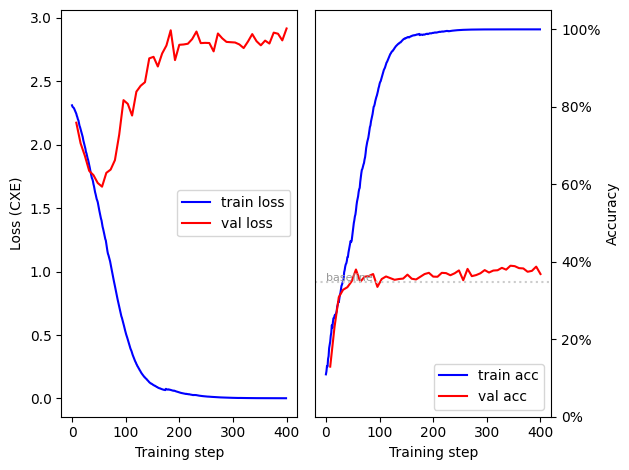

Best validation accuracy: 38.98%
----Fine-Tuning Completed. Validation Accuracy: 38.98%----


In [21]:
# re-load the backbone with saved weights from self-supervised training:
selfsup_inpainting_backbone = models.resnet18().to(device)
selfsup_inpainting_backbone.load_state_dict(torch.load('selfsupervised_inpainting_best_backbone.pt', weights_only=True))

# optionally, try freezing the backbone to avoid overfitting:
FREEZE_BACKBONE = True
layers_to_freeze = [
    selfsup_inpainting_backbone.layer1,
    selfsup_inpainting_backbone.layer2,
    selfsup_inpainting_backbone.layer3,
    # selfsup_inpainting_backbone.layer4,  # Uncomment to freeze more layers if desired
]

if FREEZE_BACKBONE:
    for layer in layers_to_freeze:
        for param in layer.parameters():
            param.requires_grad = False
    print('----Backbone layers frozen----')
else:
    print('----Backbone layers are trainable----')

# re-initialise the baseline classifier head, but attach it to the self-supervised backbone:
classification_head = ClassifierHead(input_size=1000, projection_size=256, num_classes=10, dropout=0.5).to(device)

class FineTunedInpaintingModel(nn.Module):
    def __init__(self, backbone, head):
        super(FineTunedInpaintingModel, self).__init__()
        self.backbone = backbone
        self.head = head
    
    def forward(self, x):
        features = self.backbone(x)
        out = self.head(features)
        return out
    
fine_tuned_inpainting_model = FineTunedInpaintingModel(selfsup_inpainting_backbone, classification_head).to(device)

# fine-tune:
num_epochs = 100
lr = 1e-4 
l2_reg = 1e-3

ft_acc = train_supervised(fine_tuned_inpainting_model, train_loader, val_loader, 
                           num_epochs, lr, l2_reg, baselines={'baseline': baseline_acc})
print(f'----Fine-Tuning Completed. Validation Accuracy: {ft_acc*100:.2f}%----')

### Assessment

* Report your results with **a few plots** illustrating your pretext task, and comparing the final validation accuracy of the self-supervised, fine-tuned model to the supervised baseline.
    
* Also write **a few sentences** summarising any particular issues you ran into, how you solved them, and any other insights you gained about designing/implementing your pretext task or transferring it to the downstream classifier.

Good luck! Contact me if you have any problems.